In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.finance_metrics import annualized_return
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from tensorflow.keras.preprocessing import timeseries_dataset_from_array 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GRU, SimpleRNN, Dense, Dropout, Reshape, Embedding
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [2]:
def build_RNN():
    # Generate the model architecture
    rnn_model = Sequential()
#     rnn_model.add(Reshape((21,44), input_shape=(44,)))
#     rnn_model.add(GRU(128, input_shape=(1,44), dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#     rnn_model.add(Embedding())
    rnn_model.add(GRU(128, input_shape=(21,44), dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    #input_shape = [X_train.shape[1], X_train.shape[2]]
    rnn_model.add(SimpleRNN((128)))
    rnn_model.add(Dense(128, activation='relu'))
    rnn_model.add(Dropout(0.3))
    rnn_model.add(Dense(64, activation='relu'))
    rnn_model.add(Dropout(0.3))
    rnn_model.add(Dense(32, activation='relu'))
    rnn_model.add(Dropout(0.3))
    rnn_model.add(Dense(16, activation='relu'))
    rnn_model.add(Dropout(0.3))
    rnn_model.add(Dense(1))
    # Compile the model
    rnn_model.compile(optimizer='adam', loss='mean_squared_error',
                  metrics=[MeanSquaredError(), RootMeanSquaredError()])
    return rnn_model

In [3]:
# Create a 3D input
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [6]:
data_path = r'data/processed'
data_filenames = os.listdir(data_path)

models = {}
feature_transformers = {}
feature_scalers = {}

In [7]:
for data_file in data_filenames:
    pairs = data_file[:-4].split('-')
    pair = (pairs[0], pairs[1])
    print(pair)
    

    pair_df = pd.read_pickle(os.path.join(data_path, data_file))
    X_train = pair_df.loc["2000-01-01":"2014-12-31", :].drop(columns="Return Diff (t+1)")
    y_train = pair_df.loc["2000-01-01":"2014-12-31", ["Return Diff (t+1)"]]
    X_test = pair_df.loc["2015-01-01":, :].drop(columns="Return Diff (t+1)")
    y_test = pair_df.loc["2015-01-01":, ["Return Diff (t+1)"]]

    # fill invalid values with 1 (for ratios) or 0 (for differences)
    X_train[X_train.isin([-np.inf, np.inf, np.nan])] = 1
    y_train[y_train.isin([-np.inf, np.inf, np.nan])] = 0
    X_test[X_test.isin([-np.inf, np.inf, np.nan])] = 1
    y_test[y_test.isin([-np.inf, np.inf, np.nan])] = 0

    # add in quantiles as additional feature columns
    quantile_transformer = QuantileTransformer()
    quantile_transformer.fit(X_train); feature_transformers[pair] = quantile_transformer
    X_train.loc[:, [col + "_QUANTILE" for col in X_train.columns]] = pd.DataFrame(
        pd.DataFrame(quantile_transformer.transform(X_train), index=X_train.index,
                     columns=[col + "_QUANTILE" for col in X_train.columns]))
    X_test.loc[:, [col + "_QUANTILE" for col in X_test.columns]] = pd.DataFrame(
        pd.DataFrame(quantile_transformer.transform(X_test), index=X_test.index,
                     columns=[col + "_QUANTILE" for col in X_test.columns]))

    # fill invalid values with 1 (for ratios) or 0 (for differences)
    X_train[X_train.isin([-np.inf, np.inf, np.nan])] = 1
    y_train[y_train.isin([-np.inf, np.inf, np.nan])] = 0
    X_test[X_test.isin([-np.inf, np.inf, np.nan])] = 1
    y_test[y_test.isin([-np.inf, np.inf, np.nan])] = 0

    # scale features
    X_scaler = StandardScaler()
    X_scaler.fit(X_train); feature_scalers[pair] = X_scaler
    X_train = pd.DataFrame(X_scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(X_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    assert not any([any(arr) for arr in np.array(np.isinf(X_train))])
    assert not any([any(arr) for arr in np.array(np.isnan(X_train))])
    assert not any([any(arr) for arr in np.array(np.isinf(X_test))])
    assert not any([any(arr) for arr in np.array(np.isnan(X_test))])
    assert not any([any(arr) for arr in np.array(np.isinf(y_train))])
    assert not any([any(arr) for arr in np.array(np.isnan(y_train))])
    assert not any([any(arr) for arr in np.array(np.isinf(y_test))])
    assert not any([any(arr) for arr in np.array(np.isnan(y_test))])

    split = PredefinedSplit(test_fold=[0 if v else -1 for v in X_train.index < '2012-01-01'])
    models[pair] = {
        'Random Forest': GridSearchCV(estimator=RandomForestRegressor(bootstrap=True), param_grid={
            "n_estimators": [n for n in range(50, 150, 25)]
        }, cv=split, scoring="explained_variance", n_jobs=-1),
        'Adaptive Boost': GridSearchCV(estimator=AdaBoostRegressor(), param_grid={
            "n_estimators": [n for n in range(50, 250, 50)],
            "loss": ["linear", "exponential"]
        }, cv=split, scoring="explained_variance", n_jobs=-1),
        'Gradient Boost': GridSearchCV(estimator=GradientBoostingRegressor(loss="huber"), param_grid={
            "n_estimators": [n for n in range(50, 250, 50)]
        }, cv=split, scoring="explained_variance", n_jobs=-1),
        'Neural Net': GridSearchCV(estimator=MLPRegressor(solver="lbfgs", max_iter=1000000), param_grid={
            "hidden_layer_sizes": [(250, h1, h2)
                                   for h1 in range(100, 200, 50)
                                   for h2 in range(25, h1//2, 25)]
        }, cv=split, scoring="explained_variance", n_jobs=-1),
#         'Recurrent Neural Net': KerasRegressor(nb_epoch=5000, batch_size=64, build_fn=build_RNN, verbose=False)
    }

    print(f"==================================================\n"
          f"Results for pair {pair}:\n"
          f"- Return Difference Stats:\n"
          f"  - mean: {float(np.mean(y_test)):.06f}\n"
          f"  - std: {float(np.std(y_test)):.06f}\n"
          f"  - quantiles [0.00, 0.25, 0.50, 0.75, 1.00]:\n"
          f"    {[np.round(i, decimals=6) for i in np.quantile(y_test, [0, .25, .50, .75, 1])]}")
    pred_average = None
    for model_type, model in models[pair].items():
#         print(X_train.shape, np.array(y_train).ravel().shape)
        pred = None
    
        if model_type == "Recurrent Neural Net":    
            X_train2 = np.array(X_train)
            y_train2 = np.array(y_train)
            X_test2 = np.array(X_test)
            y_test2 = np.array(y_test)

            
            TIME_STEPS = 21
            X_test2, y_test2 = create_dataset(X_test2, y_test2,   
                                            TIME_STEPS)
            X_train2, y_train2 = create_dataset(X_train2, y_train2, 
                                              TIME_STEPS)
            
#             print('X_train.shape: ', X_test.shape)
#             print('y_train.shape: ', y_train.shape)
#             print('X_test.shape: ', X_test.shape)
#             print('y_test.shape: ', y_train.shape)

            
            model.fit(X_train2, np.array(y_train2).ravel())
            pred = model.predict(X_test2)
            
        else:
            
            model.fit(X_train[:], np.array(y_train[:]).ravel())
            pred = model.predict(X_test[:]) 
            
        if model_type != "Recurrent Neural Net": 
            if pred_average is None: pred_average = pred / 4
            else: pred_average = pred_average + np.array(pred / 4)
        
        if model_type != "Recurrent Neural Net": 
            mse = mean_squared_error(np.array(y_test), np.array(pred).ravel())
            mae = median_absolute_error(np.array(y_test), np.array(pred).ravel())
            print(f"- Model: {model_type}\n"
                  f"  - best parameters: {model.best_params_}\n"
                  f"  - MSE: {mse:.06f}\n"
                  f"  - MAE: {mae:.06f}\n"
                  f"--------------------------------------------------")
        else:
            mse = mean_squared_error(np.array(y_test[21:]), np.array(pred).ravel())
            mae = median_absolute_error(np.array(y_test[21:]), np.array(pred).ravel())
            print(f"- Model: {model_type}\n"
                  f"  - MSE: {mse:.06f}\n"
                  f"  - MAE: {mae:.06f}\n"
                  f"--------------------------------------------------")
            
#     mse = mean_squared_error(np.array(y_test), np.array(pred_average).ravel())
#     mae = median_absolute_error(np.array(y_test), np.array(pred_average).ravel())
#     print(f"- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Neural Net\n"
#           f"  - MSE: {mse:.06f}\n"
#           f"  - MAE: {mae:.06f}\n"
#           f"--------------------------------------------------")
#     print(f"==================================================\n")


('ADX', 'TY')
Results for pair ('ADX', 'TY'):
- Return Difference Stats:
  - mean: -0.000025
  - std: 0.005070
  - quantiles [0.00, 0.25, 0.50, 0.75, 1.00]:
    [-0.066671, -0.002313, 6e-06, 0.002432, 0.056949]
- Model: Random Forest
  - best parameters: {'n_estimators': 50}
  - MSE: 0.000001
  - MAE: 0.000003
--------------------------------------------------
- Model: Adaptive Boost
  - best parameters: {'loss': 'exponential', 'n_estimators': 150}
  - MSE: 0.000002
  - MAE: 0.000791
--------------------------------------------------
- Model: Gradient Boost
  - best parameters: {'n_estimators': 200}
  - MSE: 0.000001
  - MAE: 0.000025
--------------------------------------------------
- Model: Neural Net
  - best parameters: {'hidden_layer_sizes': (250, 100, 25)}
  - MSE: 0.000025
  - MAE: 0.002749
--------------------------------------------------
('AEG', 'ING')
Results for pair ('AEG', 'ING'):
- Return Difference Stats:
  - mean: -0.000190
  - std: 0.016930
  - quantiles [0.00, 0.25,

Results for pair ('BEN', 'TROW'):
- Return Difference Stats:
  - mean: -0.000899
  - std: 0.013505
  - quantiles [0.00, 0.25, 0.50, 0.75, 1.00]:
    [-0.138443, -0.007484, -0.000766, 0.005552, 0.080549]
- Model: Random Forest
  - best parameters: {'n_estimators': 100}
  - MSE: 0.000001
  - MAE: 0.000007
--------------------------------------------------
- Model: Adaptive Boost
  - best parameters: {'loss': 'exponential', 'n_estimators': 100}
  - MSE: 0.000006
  - MAE: 0.001978
--------------------------------------------------
- Model: Gradient Boost
  - best parameters: {'n_estimators': 150}
  - MSE: 0.000001
  - MAE: 0.000080
--------------------------------------------------
- Model: Neural Net
  - best parameters: {'hidden_layer_sizes': (250, 100, 25)}
  - MSE: 0.000046
  - MAE: 0.004348
--------------------------------------------------
('BK', 'NTRS')
Results for pair ('BK', 'NTRS'):
- Return Difference Stats:
  - mean: -0.000181
  - std: 0.010479
  - quantiles [0.00, 0.25, 0.50, 

Results for pair ('CSX', 'NSC'):
- Return Difference Stats:
  - mean: 0.000020
  - std: 0.011392
  - quantiles [0.00, 0.25, 0.50, 0.75, 1.00]:
    [-0.084522, -0.005784, 4.3e-05, 0.005721, 0.150737]
- Model: Random Forest
  - best parameters: {'n_estimators': 125}
  - MSE: 0.000004
  - MAE: 0.000006
--------------------------------------------------
- Model: Adaptive Boost
  - best parameters: {'loss': 'linear', 'n_estimators': 150}
  - MSE: 0.000005
  - MAE: 0.001244
--------------------------------------------------
- Model: Gradient Boost
  - best parameters: {'n_estimators': 200}
  - MSE: 0.000006
  - MAE: 0.000075
--------------------------------------------------
- Model: Neural Net
  - best parameters: {'hidden_layer_sizes': (250, 150, 25)}
  - MSE: 0.000055
  - MAE: 0.003064
--------------------------------------------------
('CUZ', 'WRE')
Results for pair ('CUZ', 'WRE'):
- Return Difference Stats:
  - mean: 0.000078
  - std: 0.012461
  - quantiles [0.00, 0.25, 0.50, 0.75, 1.00

Results for pair ('FRT', 'REG'):
- Return Difference Stats:
  - mean: -0.000067
  - std: 0.008001
  - quantiles [0.00, 0.25, 0.50, 0.75, 1.00]:
    [-0.061305, -0.004199, -0.000152, 0.003982, 0.047309]
- Model: Random Forest
  - best parameters: {'n_estimators': 50}
  - MSE: 0.000000
  - MAE: 0.000005
--------------------------------------------------
- Model: Adaptive Boost
  - best parameters: {'loss': 'linear', 'n_estimators': 50}
  - MSE: 0.000002
  - MAE: 0.001072
--------------------------------------------------
- Model: Gradient Boost
  - best parameters: {'n_estimators': 150}
  - MSE: 0.000000
  - MAE: 0.000044
--------------------------------------------------
- Model: Neural Net
  - best parameters: {'hidden_layer_sizes': (250, 150, 25)}
  - MSE: 0.000018
  - MAE: 0.002596
--------------------------------------------------
('FULT', 'VLY')
Results for pair ('FULT', 'VLY'):
- Return Difference Stats:
  - mean: -0.000049
  - std: 0.010207
  - quantiles [0.00, 0.25, 0.50, 0.75, 

Results for pair ('HQH', 'HQL'):
- Return Difference Stats:
  - mean: -0.000049
  - std: 0.006084
  - quantiles [0.00, 0.25, 0.50, 0.75, 1.00]:
    [-0.038381, -0.003541, -4.1e-05, 0.003493, 0.032555]
- Model: Random Forest
  - best parameters: {'n_estimators': 75}
  - MSE: 0.000000
  - MAE: 0.000004
--------------------------------------------------
- Model: Adaptive Boost
  - best parameters: {'loss': 'exponential', 'n_estimators': 200}
  - MSE: 0.000007
  - MAE: 0.002652
--------------------------------------------------
- Model: Gradient Boost
  - best parameters: {'n_estimators': 150}
  - MSE: 0.000000
  - MAE: 0.000034
--------------------------------------------------
- Model: Neural Net
  - best parameters: {'hidden_layer_sizes': (250, 100, 25)}
  - MSE: 0.000018
  - MAE: 0.002665
--------------------------------------------------
('IAC', 'MTCH')
Results for pair ('IAC', 'MTCH'):
- Return Difference Stats:
  - mean: 0.000209
  - std: 0.011159
  - quantiles [0.00, 0.25, 0.50, 0.

Results for pair ('PEAK', 'WELL'):
- Return Difference Stats:
  - mean: -0.000057
  - std: 0.012717
  - quantiles [0.00, 0.25, 0.50, 0.75, 1.00]:
    [-0.226519, -0.005038, 8.2e-05, 0.004993, 0.073329]
- Model: Random Forest
  - best parameters: {'n_estimators': 50}
  - MSE: 0.000019
  - MAE: 0.000006
--------------------------------------------------
- Model: Adaptive Boost
  - best parameters: {'loss': 'exponential', 'n_estimators': 50}
  - MSE: 0.000021
  - MAE: 0.001186
--------------------------------------------------
- Model: Gradient Boost
  - best parameters: {'n_estimators': 200}
  - MSE: 0.000017
  - MAE: 0.000051
--------------------------------------------------
- Model: Neural Net
  - best parameters: {'hidden_layer_sizes': (250, 150, 50)}
  - MSE: 0.000027
  - MAE: 0.002445
--------------------------------------------------
('PNC', 'USB')
Results for pair ('PNC', 'USB'):
- Return Difference Stats:
  - mean: 0.000315
  - std: 0.008725
  - quantiles [0.00, 0.25, 0.50, 0.75

In [8]:
conf_mat_all = None
for data_file in data_filenames:
    pairs = data_file[:-4].split('-')
    pair = (pairs[0], pairs[1])
    print(pair)

    pair_df = pd.read_pickle(os.path.join(data_path, data_file))
    X_train = pair_df.loc["2000-01-01":"2014-12-31", :].drop(columns="Return Diff (t+1)")
    y_train = pair_df.loc["2000-01-01":"2014-12-31", ["Return Diff (t+1)"]]
    X_test = pair_df.loc["2015-01-01":, :].drop(columns="Return Diff (t+1)")
    y_test = pair_df.loc["2015-01-01":, ["Return Diff (t+1)"]]

    # fill invalid values with 1 (for ratios) or 0 (for differences)
    X_train[X_train.isin([-np.inf, np.inf, np.nan])] = 1
    y_train[y_train.isin([-np.inf, np.inf, np.nan])] = 0
    X_test[X_test.isin([-np.inf, np.inf, np.nan])] = 1
    y_test[y_test.isin([-np.inf, np.inf, np.nan])] = 0

    # add in quantiles as additional feature columns
    quantile_transformer = feature_transformers[pair]
    X_train.loc[:, [col + "_QUANTILE" for col in X_train.columns]] = pd.DataFrame(
        pd.DataFrame(quantile_transformer.transform(X_train), index=X_train.index,
                     columns=[col + "_QUANTILE" for col in X_train.columns]))
    X_test.loc[:, [col + "_QUANTILE" for col in X_test.columns]] = pd.DataFrame(
        pd.DataFrame(quantile_transformer.transform(X_test), index=X_test.index,
                     columns=[col + "_QUANTILE" for col in X_test.columns]))

    # fill invalid values with 1 (for ratios) or 0 (for differences)
    X_train[X_train.isin([-np.inf, np.inf, np.nan])] = 1
    X_test[X_test.isin([-np.inf, np.inf, np.nan])] = 1

    # scale features
    X_scaler = feature_scalers[pair]
    X_train = pd.DataFrame(X_scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(X_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    assert not any([any(arr) for arr in np.array(np.isinf(X_train))])
    assert not any([any(arr) for arr in np.array(np.isnan(X_train))])
    assert not any([any(arr) for arr in np.array(np.isinf(X_test))])
    assert not any([any(arr) for arr in np.array(np.isnan(X_test))])
    assert not any([any(arr) for arr in np.array(np.isinf(y_train))])
    assert not any([any(arr) for arr in np.array(np.isnan(y_train))])
    assert not any([any(arr) for arr in np.array(np.isinf(y_test))])
    assert not any([any(arr) for arr in np.array(np.isnan(y_test))])

    print(f"==================================================\n"
          f"Results for pair {pair}:")
    pred_ensemble = None
    for model_type, model in models[pair].items():
        pred = [-1 if i < 0 else 1 for i in np.array(model.predict(X_test)).ravel()]
        if pred_ensemble is None: pred_ensemble = np.array(pred) / 4
        else: pred_ensemble = pred_ensemble + (np.array(pred) / 4)

        conf_mat = confusion_matrix(
            [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
            [0 if i < 0 else 1 for i in np.array(pred).ravel()])
        accuracy = accuracy_score(
            [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
            [0 if i < 0 else 1 for i in np.array(pred).ravel()])
        precision = precision_score(
            [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
            [0 if i < 0 else 1 for i in np.array(pred).ravel()])
        recall = recall_score(
            [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
            [0 if i < 0 else 1 for i in np.array(pred).ravel()])
        f1 = f1_score(
            [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
            [0 if i < 0 else 1 for i in np.array(pred).ravel()])

        print(f"- Model: {model_type}\n"
              f"  - Confusion Matrix:\n{conf_mat}\n"
              f"  - Accuracy: {accuracy:.06f}\n"
              f"  - Recall: {recall:.06f}\n"
              f"  - Precision: {precision:.06f}\n"
              f"  - F1-Score: {f1:.06f}\n"
              f"--------------------------------------------------")

    conf_mat = confusion_matrix(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    accuracy = accuracy_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    precision = precision_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    recall = recall_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    f1 = f1_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])

    if conf_mat_all is None: conf_mat_all = np.array(conf_mat)
    else: conf_mat_all = conf_mat_all + np.array(conf_mat)

    print(f"- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Neural Net\n"
          f"  - Confusion Matrix:\n{conf_mat}\n"
          f"  - Accuracy: {accuracy:.06f}\n"
          f"  - Recall: {recall:.06f}\n"
          f"  - Precision: {precision:.06f}\n"
          f"  - F1-Score: {f1:.06f}\n"
          f"--------------------------------------------------")
    print(f"==================================================\n")


print(f"- Confusion Matrix of ensemble prediction across all pairs\n{conf_mat_all}\n"
      f"  - Accuracy: {(conf_mat_all[0][0]+conf_mat_all[1][1]) / np.sum(conf_mat_all):.06f}\n"
      f"--------------------------------------------------")
print(f"==================================================\n")

('ADX', 'TY')
Results for pair ('ADX', 'TY'):
- Model: Random Forest
  - Confusion Matrix:
[[771   0]
 [  2 777]]
  - Accuracy: 0.998710
  - Recall: 0.997433
  - Precision: 1.000000
  - F1-Score: 0.998715
--------------------------------------------------
- Model: Adaptive Boost
  - Confusion Matrix:
[[615 156]
 [  0 779]]
  - Accuracy: 0.899355
  - Recall: 1.000000
  - Precision: 0.833155
  - F1-Score: 0.908985
--------------------------------------------------
- Model: Gradient Boost
  - Confusion Matrix:
[[771   0]
 [ 19 760]]
  - Accuracy: 0.987742
  - Recall: 0.975610
  - Precision: 1.000000
  - F1-Score: 0.987654
--------------------------------------------------
- Model: Neural Net
  - Confusion Matrix:
[[578 193]
 [228 551]]
  - Accuracy: 0.728387
  - Recall: 0.707317
  - Precision: 0.740591
  - F1-Score: 0.723572
--------------------------------------------------
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Neural Net
  - Confusion Matrix:
[[695  76]
 [  1 

Results for pair ('BAC', 'WFC'):
- Model: Random Forest
  - Confusion Matrix:
[[749   0]
 [  4 797]]
  - Accuracy: 0.997419
  - Recall: 0.995006
  - Precision: 1.000000
  - F1-Score: 0.997497
--------------------------------------------------
- Model: Adaptive Boost
  - Confusion Matrix:
[[749   0]
 [173 628]]
  - Accuracy: 0.888387
  - Recall: 0.784020
  - Precision: 1.000000
  - F1-Score: 0.878936
--------------------------------------------------
- Model: Gradient Boost
  - Confusion Matrix:
[[745   4]
 [  0 801]]
  - Accuracy: 0.997419
  - Recall: 1.000000
  - Precision: 0.995031
  - F1-Score: 0.997509
--------------------------------------------------
- Model: Neural Net
  - Confusion Matrix:
[[702  47]
 [105 696]]
  - Accuracy: 0.901935
  - Recall: 0.868914
  - Precision: 0.936743
  - F1-Score: 0.901554
--------------------------------------------------
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Neural Net
  - Confusion Matrix:
[[746   3]
 [  3 798]]
  - Acc

- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Neural Net
  - Confusion Matrix:
[[770   2]
 [  0 778]]
  - Accuracy: 0.998710
  - Recall: 1.000000
  - Precision: 0.997436
  - F1-Score: 0.998716
--------------------------------------------------

('CM', 'TD')
Results for pair ('CM', 'TD'):
- Model: Random Forest
  - Confusion Matrix:
[[761   1]
 [  0 788]]
  - Accuracy: 0.999355
  - Recall: 1.000000
  - Precision: 0.998733
  - F1-Score: 0.999366
--------------------------------------------------
- Model: Adaptive Boost
  - Confusion Matrix:
[[755   7]
 [  0 788]]
  - Accuracy: 0.995484
  - Recall: 1.000000
  - Precision: 0.991195
  - F1-Score: 0.995578
--------------------------------------------------
- Model: Gradient Boost
  - Confusion Matrix:
[[762   0]
 [ 11 777]]
  - Accuracy: 0.992903
  - Recall: 0.986041
  - Precision: 1.000000
  - F1-Score: 0.992971
--------------------------------------------------
- Model: Neural Net
  - Confusion Matrix:
[[699  63]
 [119 6

Results for pair ('DHI', 'LEN'):
- Model: Random Forest
  - Confusion Matrix:
[[757   0]
 [  0 793]]
  - Accuracy: 1.000000
  - Recall: 1.000000
  - Precision: 1.000000
  - F1-Score: 1.000000
--------------------------------------------------
- Model: Adaptive Boost
  - Confusion Matrix:
[[708  49]
 [  0 793]]
  - Accuracy: 0.968387
  - Recall: 1.000000
  - Precision: 0.941805
  - F1-Score: 0.970031
--------------------------------------------------
- Model: Gradient Boost
  - Confusion Matrix:
[[757   0]
 [ 28 765]]
  - Accuracy: 0.981935
  - Recall: 0.964691
  - Precision: 1.000000
  - F1-Score: 0.982028
--------------------------------------------------
- Model: Neural Net
  - Confusion Matrix:
[[620 137]
 [ 42 751]]
  - Accuracy: 0.884516
  - Recall: 0.947037
  - Precision: 0.845721
  - F1-Score: 0.893516
--------------------------------------------------
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Neural Net
  - Confusion Matrix:
[[726  31]
 [  0 793]]
  - Acc

Results for pair ('FULT', 'VLY'):
- Model: Random Forest
  - Confusion Matrix:
[[800   0]
 [  0 750]]
  - Accuracy: 1.000000
  - Recall: 1.000000
  - Precision: 1.000000
  - F1-Score: 1.000000
--------------------------------------------------
- Model: Adaptive Boost
  - Confusion Matrix:
[[800   0]
 [ 18 732]]
  - Accuracy: 0.988387
  - Recall: 0.976000
  - Precision: 1.000000
  - F1-Score: 0.987854
--------------------------------------------------
- Model: Gradient Boost
  - Confusion Matrix:
[[800   0]
 [ 13 737]]
  - Accuracy: 0.991613
  - Recall: 0.982667
  - Precision: 1.000000
  - F1-Score: 0.991258
--------------------------------------------------
- Model: Neural Net
  - Confusion Matrix:
[[724  76]
 [ 68 682]]
  - Accuracy: 0.907097
  - Recall: 0.909333
  - Precision: 0.899736
  - F1-Score: 0.904509
--------------------------------------------------
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Neural Net
  - Confusion Matrix:
[[800   0]
 [  5 745]]
  - Ac

Results for pair ('HP', 'PTEN'):
- Model: Random Forest
  - Confusion Matrix:
[[773   0]
 [  0 777]]
  - Accuracy: 1.000000
  - Recall: 1.000000
  - Precision: 1.000000
  - F1-Score: 1.000000
--------------------------------------------------
- Model: Adaptive Boost
  - Confusion Matrix:
[[773   0]
 [127 650]]
  - Accuracy: 0.918065
  - Recall: 0.836551
  - Precision: 1.000000
  - F1-Score: 0.911002
--------------------------------------------------
- Model: Gradient Boost
  - Confusion Matrix:
[[772   1]
 [  0 777]]
  - Accuracy: 0.999355
  - Recall: 1.000000
  - Precision: 0.998715
  - F1-Score: 0.999357
--------------------------------------------------
- Model: Neural Net
  - Confusion Matrix:
[[742  31]
 [ 82 695]]
  - Accuracy: 0.927097
  - Recall: 0.894466
  - Precision: 0.957300
  - F1-Score: 0.924817
--------------------------------------------------
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Neural Net
  - Confusion Matrix:
[[772   1]
 [  0 777]]
  - Acc

- Model: Adaptive Boost
  - Confusion Matrix:
[[809   0]
 [340 401]]
  - Accuracy: 0.780645
  - Recall: 0.541161
  - Precision: 1.000000
  - F1-Score: 0.702277
--------------------------------------------------
- Model: Gradient Boost
  - Confusion Matrix:
[[809   0]
 [  7 734]]
  - Accuracy: 0.995484
  - Recall: 0.990553
  - Precision: 1.000000
  - F1-Score: 0.995254
--------------------------------------------------
- Model: Neural Net
  - Confusion Matrix:
[[663 146]
 [ 54 687]]
  - Accuracy: 0.870968
  - Recall: 0.927126
  - Precision: 0.824730
  - F1-Score: 0.872935
--------------------------------------------------
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Neural Net
  - Confusion Matrix:
[[808   1]
 [  4 737]]
  - Accuracy: 0.996774
  - Recall: 0.994602
  - Precision: 0.998645
  - F1-Score: 0.996619
--------------------------------------------------

('MRO', 'MUR')
Results for pair ('MRO', 'MUR'):
- Model: Random Forest
  - Confusion Matrix:
[[789   0]
 [ 

('ADX', 'TY')
Results for pair ('ADX', 'TY'):
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Recurrent Neural Net
  - Confusion Matrix:
[[695  76]
 [  1 778]]
  - Accuracy: 0.950323
  - Recall: 0.998716
  - Precision: 0.911007
  - F1-Score: 0.952848
- Annualized Return:
  - ADX: 0.069928
  - TY: 0.077630
  - Pairs Trade: 0.202033
--------------------------------------------------

('AEG', 'ING')
Results for pair ('AEG', 'ING'):
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Recurrent Neural Net
  - Confusion Matrix:
[[777   0]
 [  2 771]]
  - Accuracy: 0.998710
  - Recall: 0.997413
  - Precision: 1.000000
  - F1-Score: 0.998705
- Annualized Return:
  - AEG: -0.168048
  - ING: -0.120698
  - Pairs Trade: 0.979581
--------------------------------------------------

('AMAT', 'KLAC')
Results for pair ('AMAT', 'KLAC'):
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Recurrent Neural Net
  - Confusion Matrix:
[[773   5]
 [  0 772]]
  - Accu

<ipython-input-10-61ac765e66b7>:112: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(11, 9))


('BMO', 'RY')
Results for pair ('BMO', 'RY'):
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Recurrent Neural Net
  - Confusion Matrix:
[[621 172]
 [  0 757]]
  - Accuracy: 0.889032
  - Recall: 1.000000
  - Precision: 0.814855
  - F1-Score: 0.897983
- Annualized Return:
  - BMO: -0.001522
  - RY: 0.032806
  - Pairs Trade: 0.316109
--------------------------------------------------

('BXP', 'VNO')
Results for pair ('BXP', 'VNO'):
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Recurrent Neural Net
  - Confusion Matrix:
[[722   3]
 [  0 825]]
  - Accuracy: 0.998065
  - Recall: 1.000000
  - Precision: 0.996377
  - F1-Score: 0.998185
- Annualized Return:
  - BXP: -0.093494
  - VNO: -0.168878
  - Pairs Trade: 0.535253
--------------------------------------------------

('CCL', 'RCL')
Results for pair ('CCL', 'RCL'):
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Recurrent Neural Net
  - Confusion Matrix:
[[770   2]
 [  0 778]]
  - Accurac

('FULT', 'VLY')
Results for pair ('FULT', 'VLY'):
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Recurrent Neural Net
  - Confusion Matrix:
[[800   0]
 [  5 745]]
  - Accuracy: 0.996774
  - Recall: 0.993333
  - Precision: 1.000000
  - F1-Score: 0.996656
- Annualized Return:
  - FULT: -0.036980
  - VLY: -0.023164
  - Pairs Trade: 0.522454
--------------------------------------------------

('GAM', 'USA')
Results for pair ('GAM', 'USA'):
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Recurrent Neural Net
  - Confusion Matrix:
[[774  28]
 [  1 747]]
  - Accuracy: 0.981290
  - Recall: 0.998663
  - Precision: 0.963871
  - F1-Score: 0.980959
- Annualized Return:
  - GAM: 0.034965
  - USA: 0.081117
  - Pairs Trade: 0.326833
--------------------------------------------------

('GFI', 'HMY')
Results for pair ('GFI', 'HMY'):
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Recurrent Neural Net
  - Confusion Matrix:
[[734  16]
 [  2 798]]
  - Ac

('PEAK', 'WELL')
Results for pair ('PEAK', 'WELL'):
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Recurrent Neural Net
  - Confusion Matrix:
[[766   1]
 [  3 780]]
  - Accuracy: 0.997419
  - Recall: 0.996169
  - Precision: 0.998720
  - F1-Score: 0.997442
- Annualized Return:
  - PEAK: -0.099975
  - WELL: -0.100102
  - Pairs Trade: 0.564324
--------------------------------------------------

('PNC', 'USB')
Results for pair ('PNC', 'USB'):
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Recurrent Neural Net
  - Confusion Matrix:
[[679  54]
 [  0 817]]
  - Accuracy: 0.965161
  - Recall: 1.000000
  - Precision: 0.938002
  - F1-Score: 0.968009
- Annualized Return:
  - PNC: 0.039018
  - USB: -0.036612
  - Pairs Trade: 0.438904
--------------------------------------------------

('RMT', 'RVT')
Results for pair ('RMT', 'RVT'):
- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Recurrent Neural Net
  - Confusion Matrix:
[[765   1]
 [  0 784]]
  

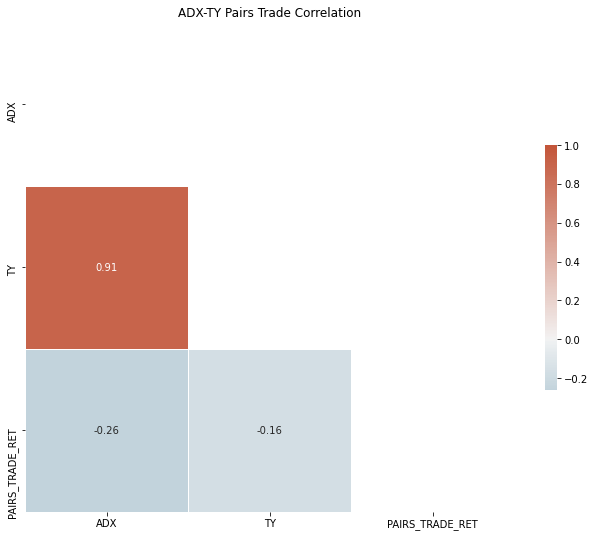

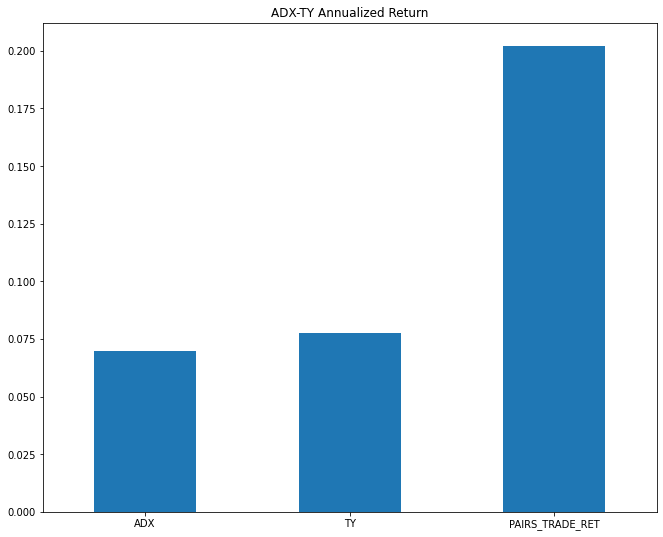

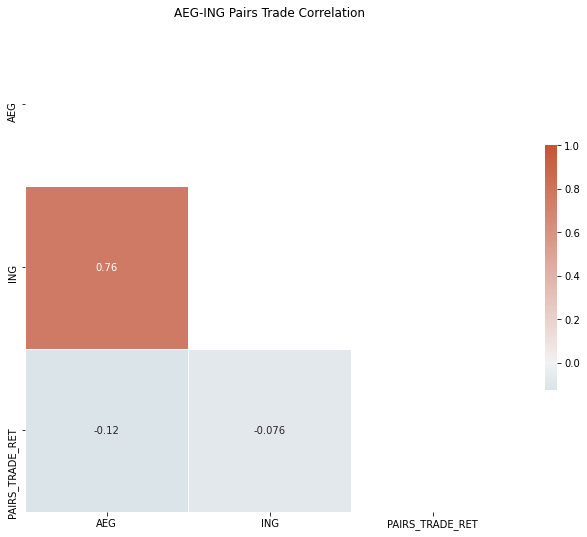

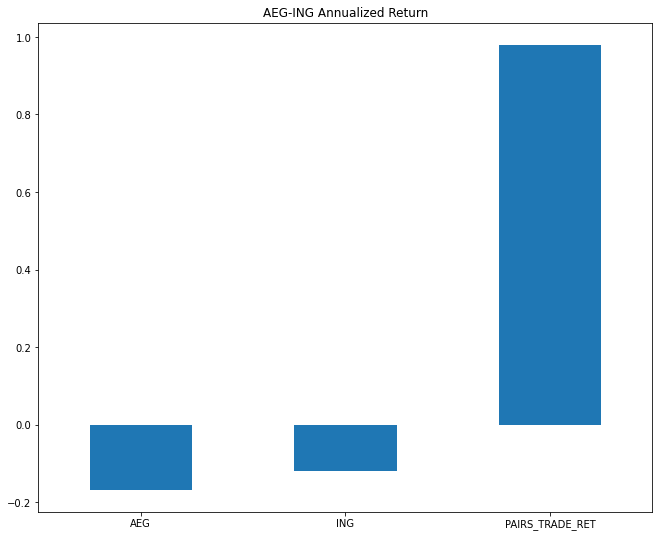

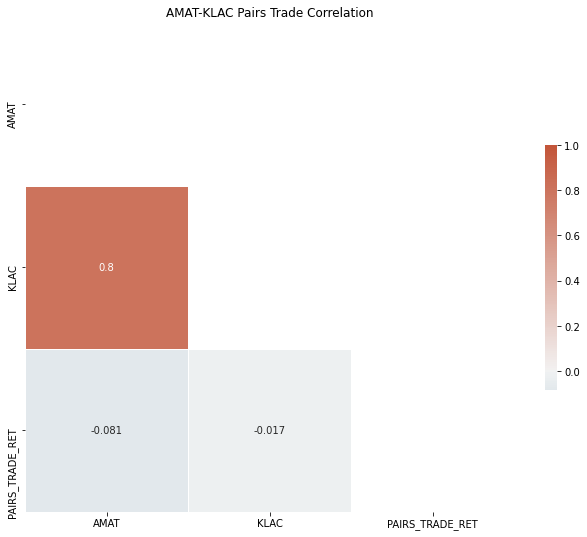

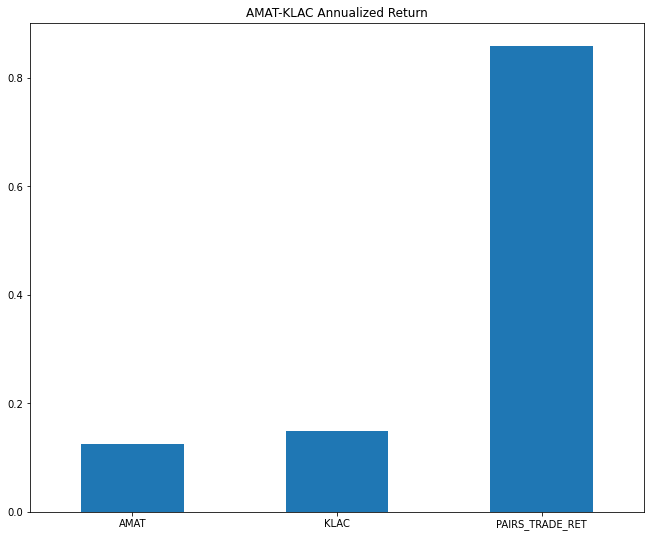

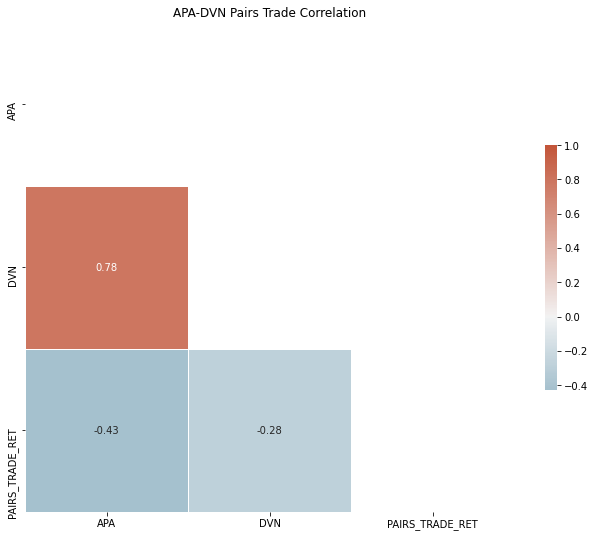

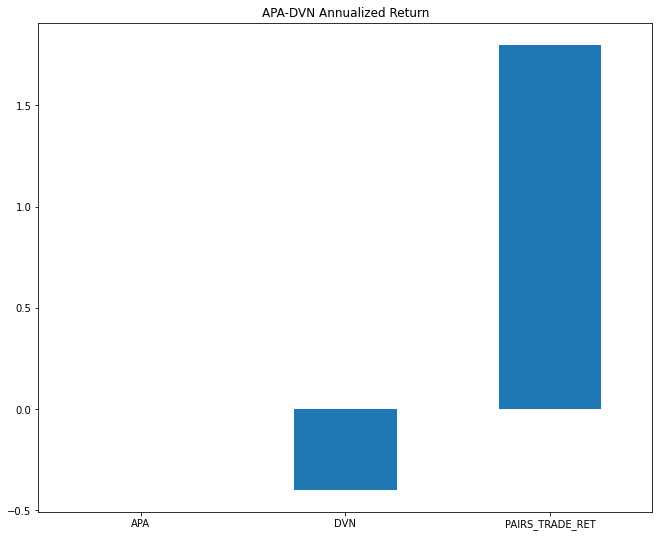

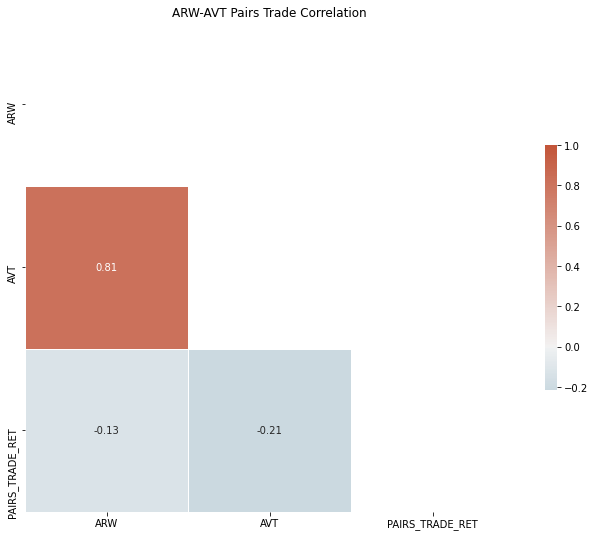

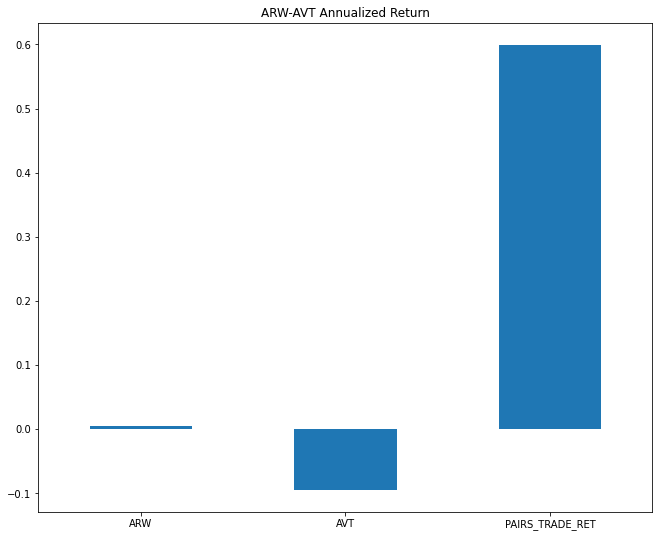

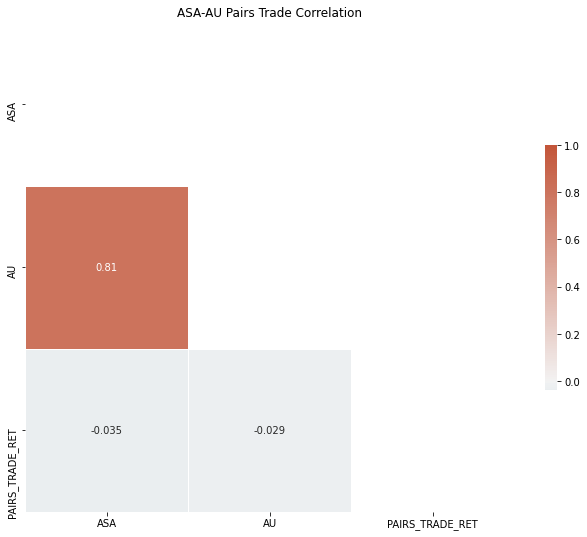

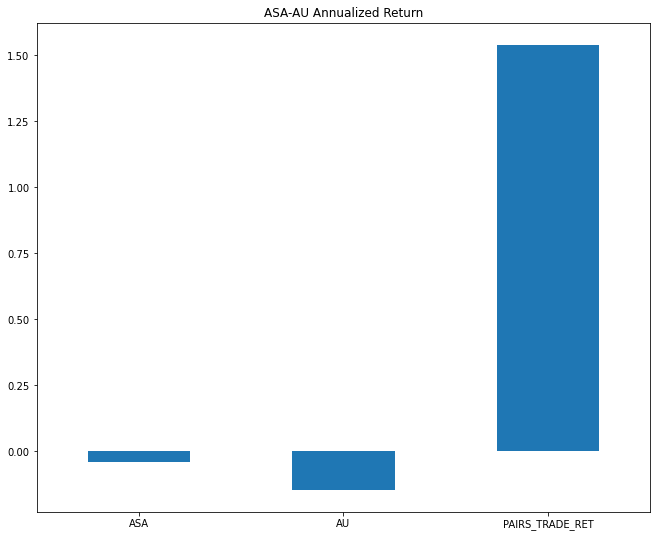

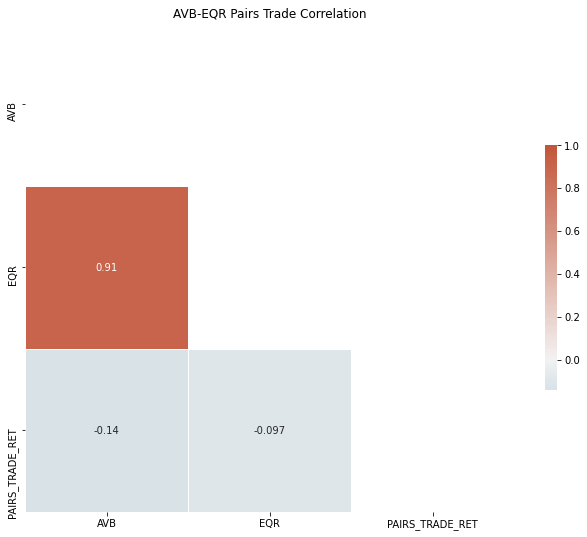

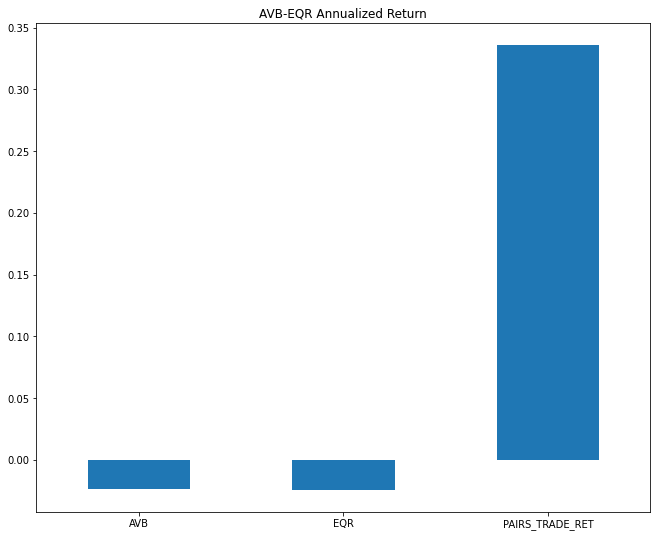

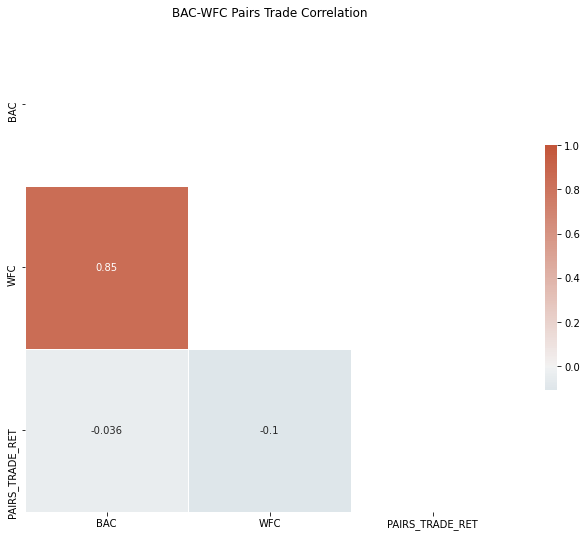

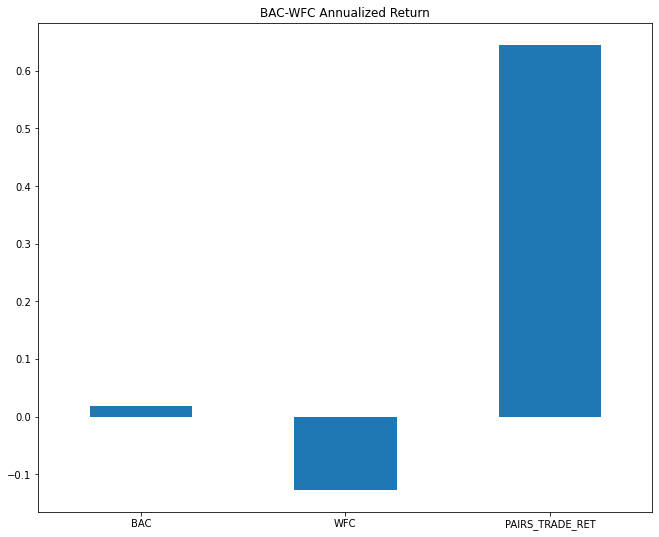

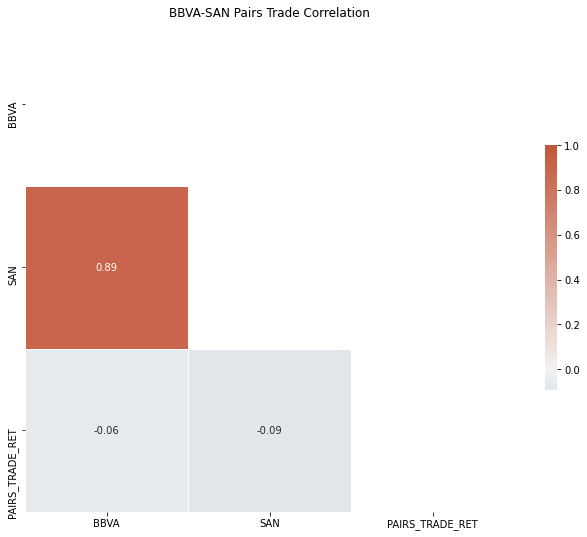

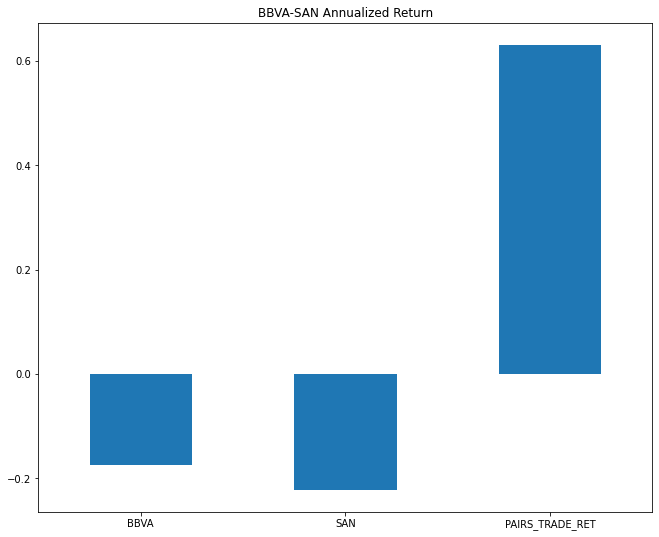

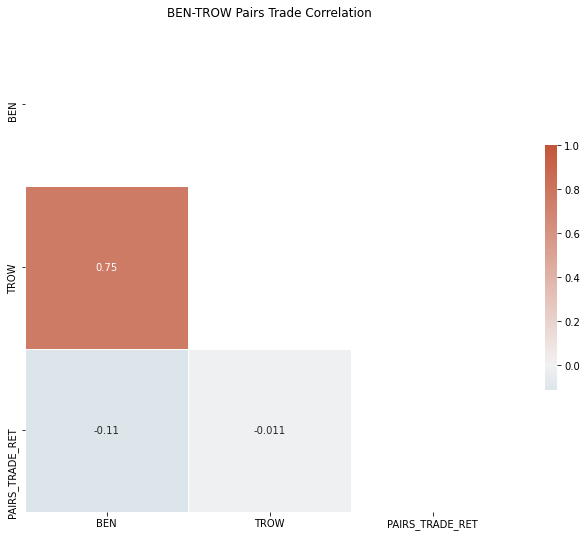

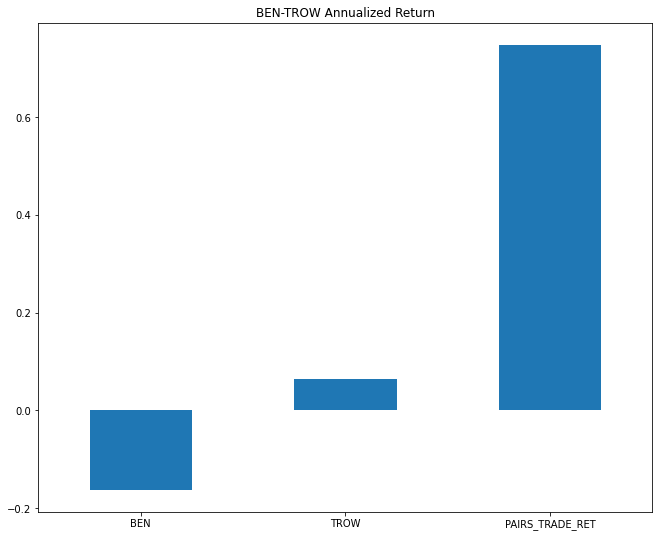

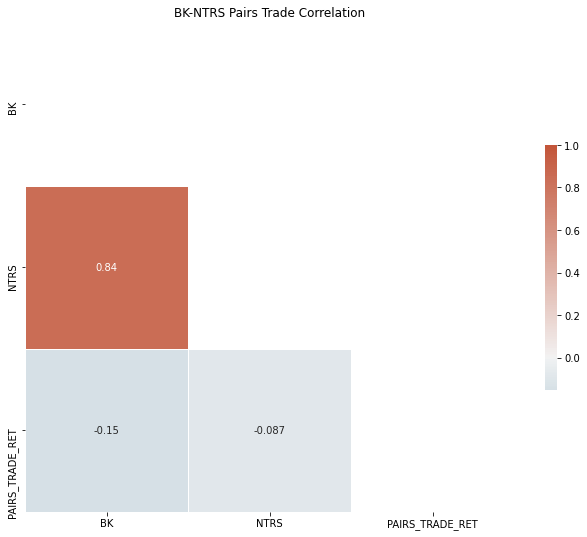

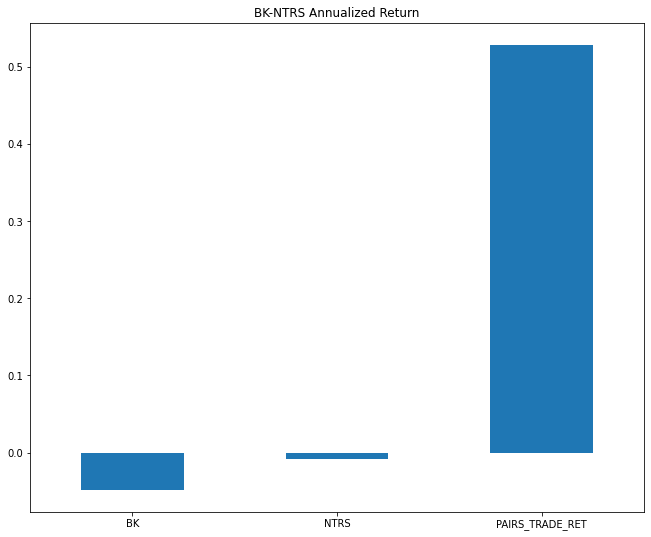

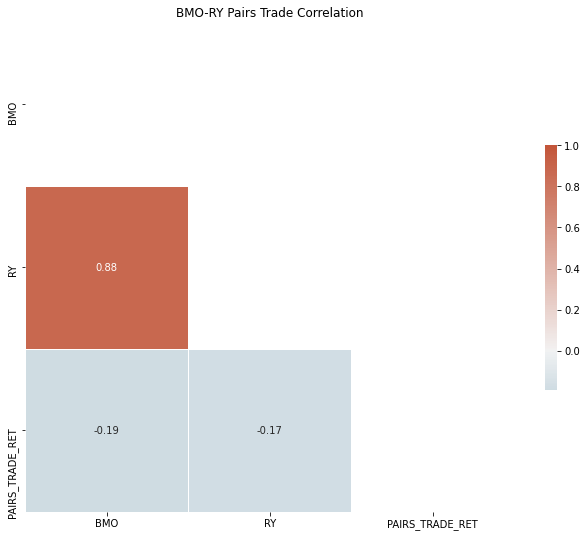

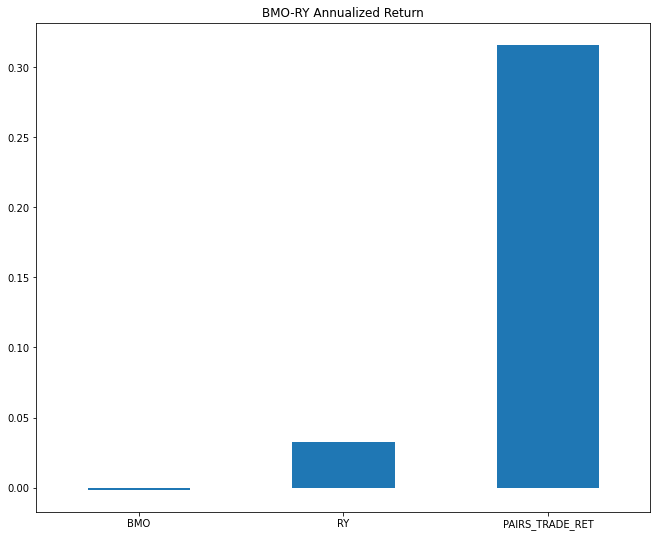

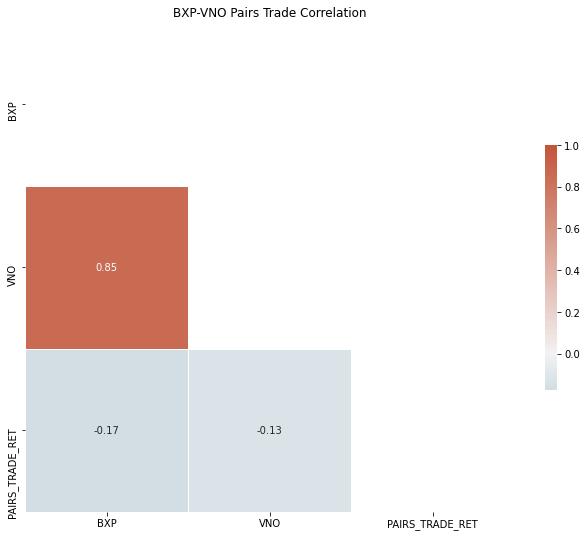

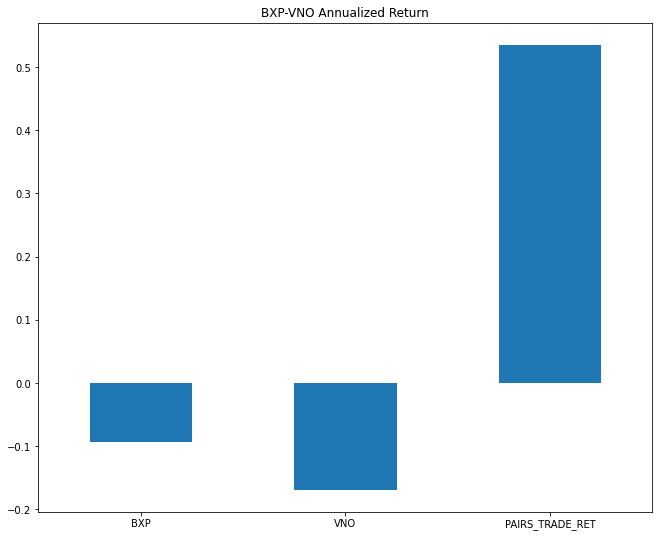

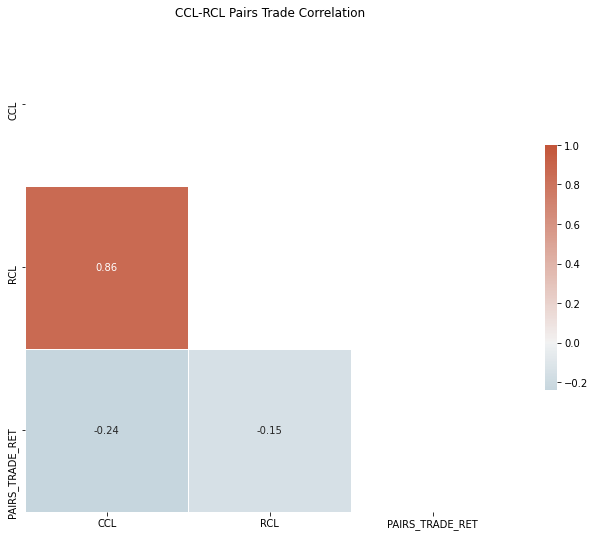

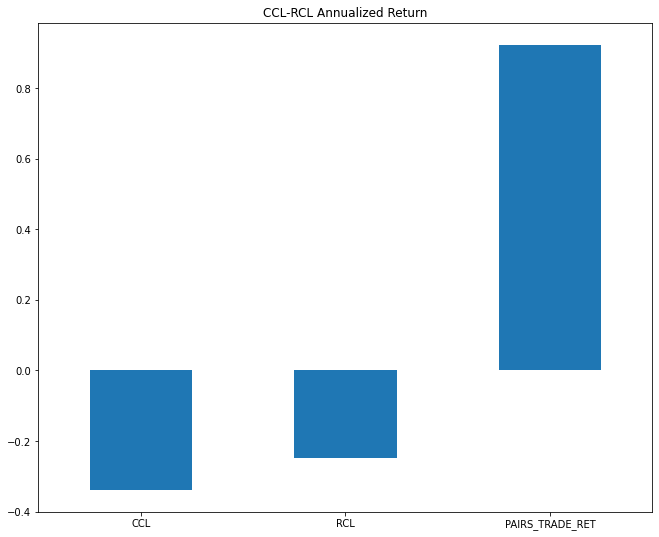

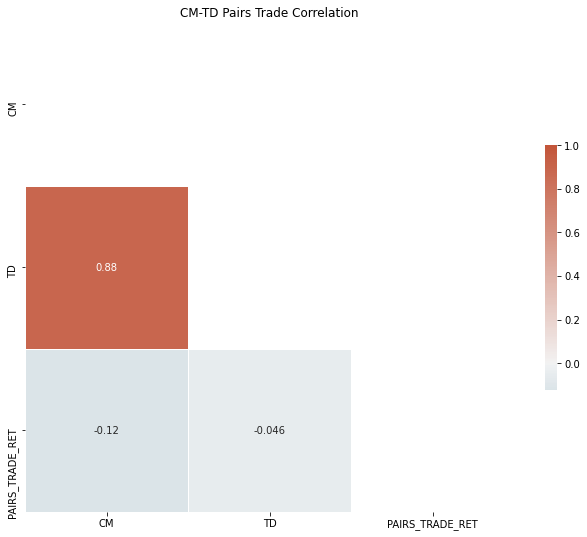

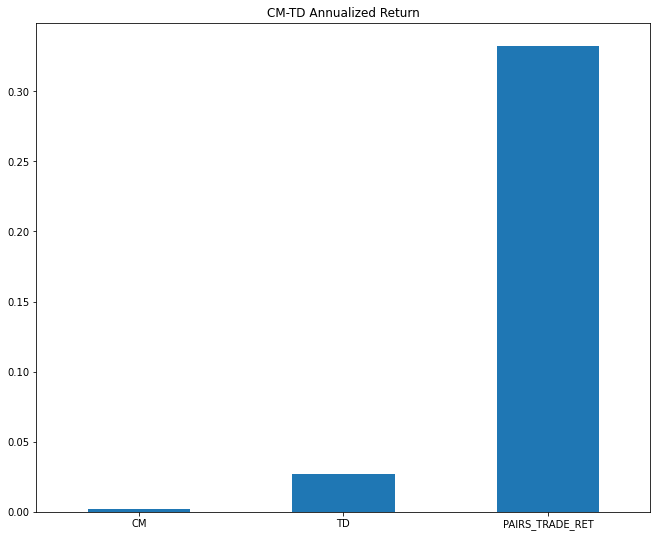

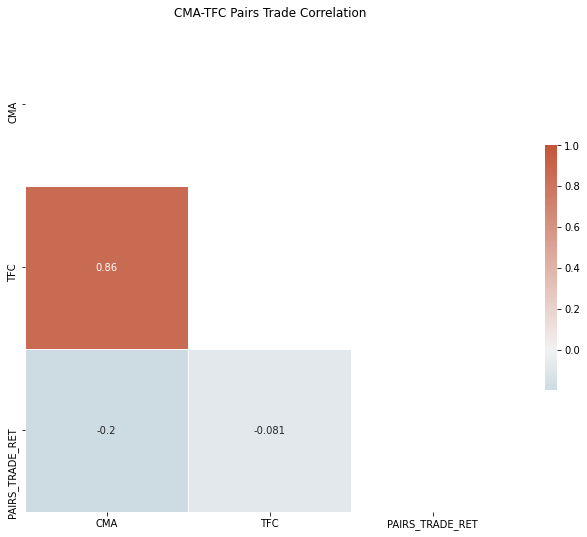

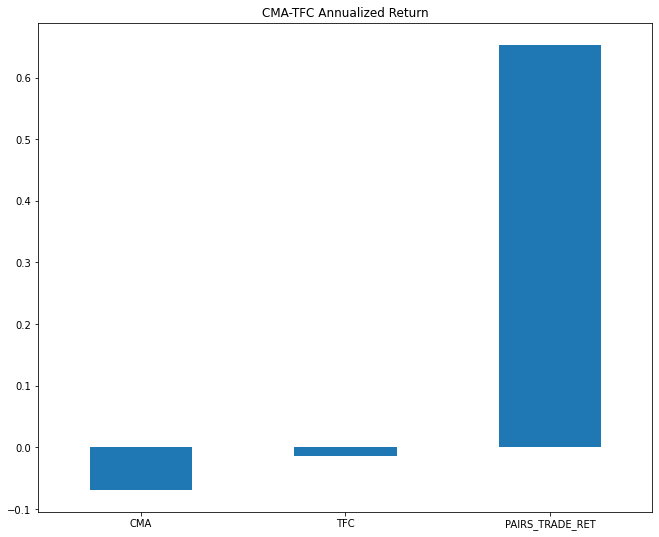

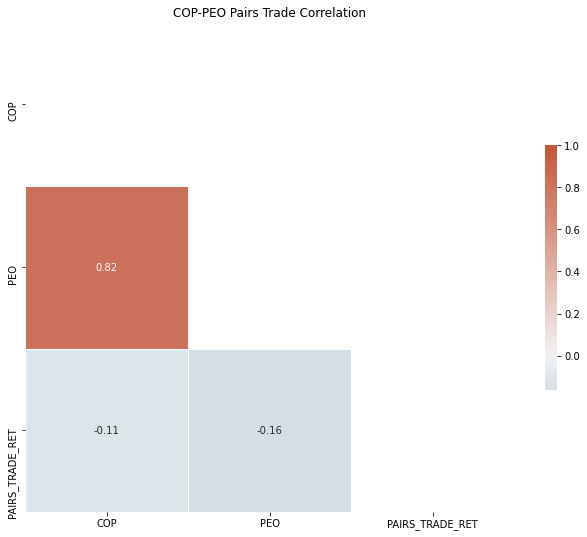

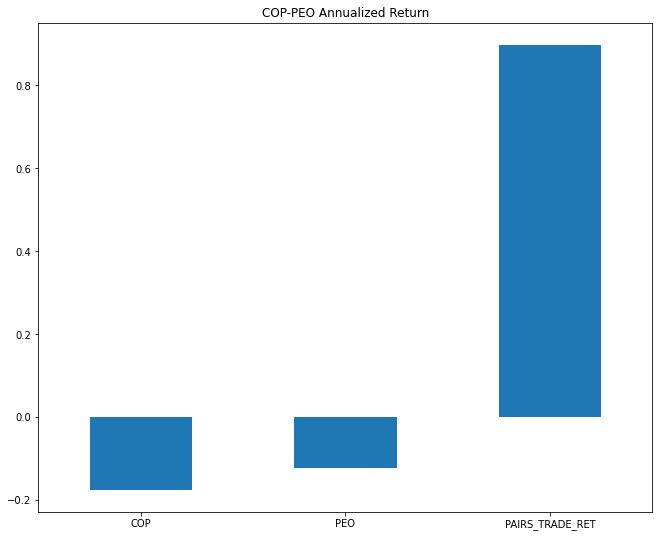

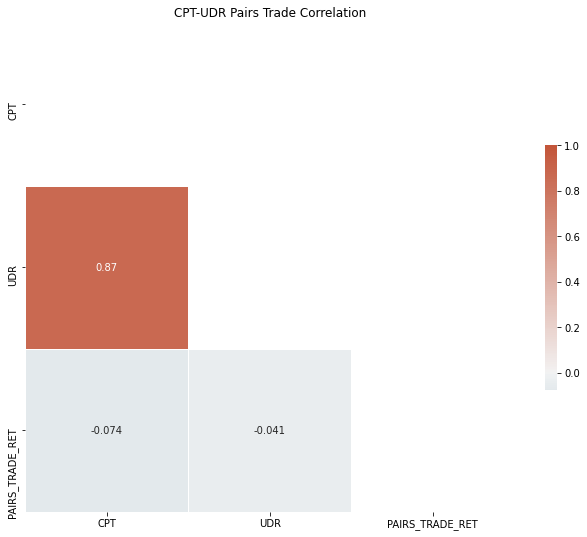

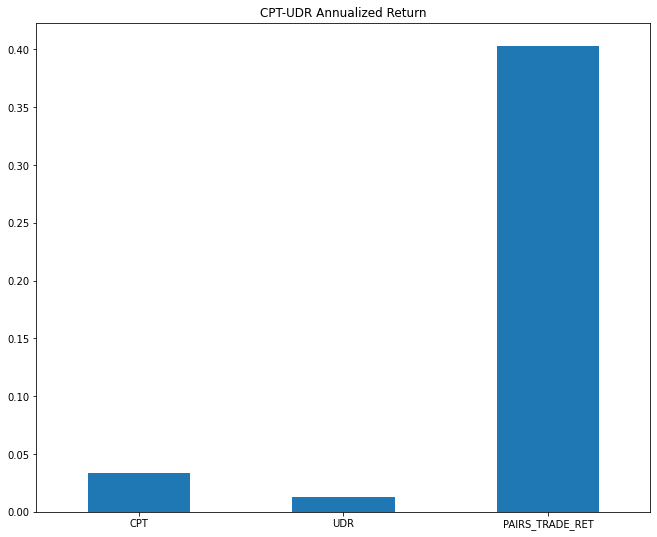

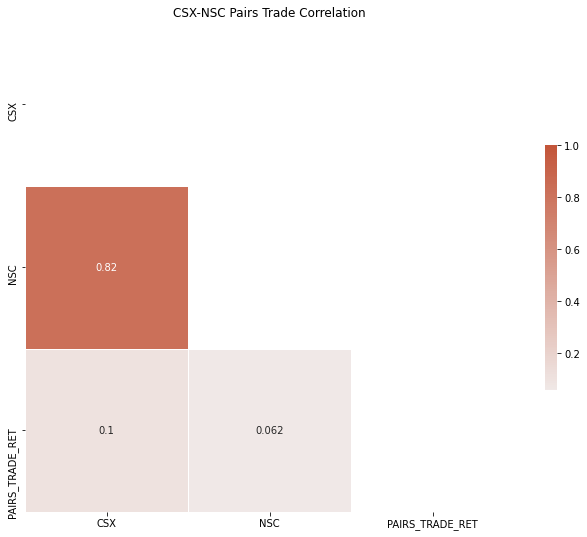

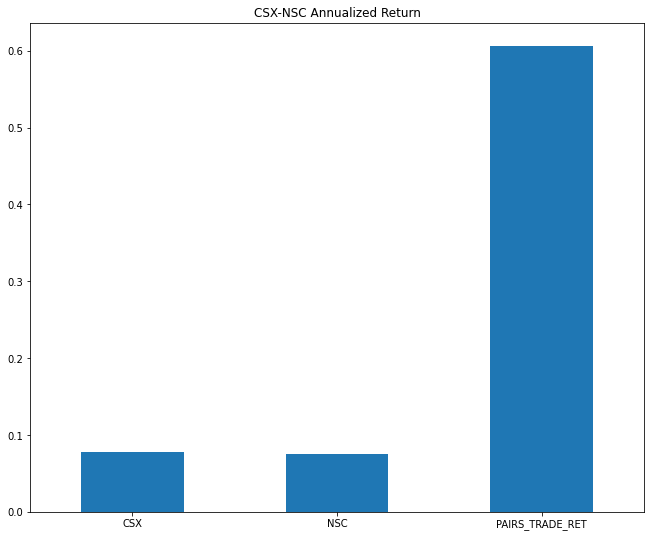

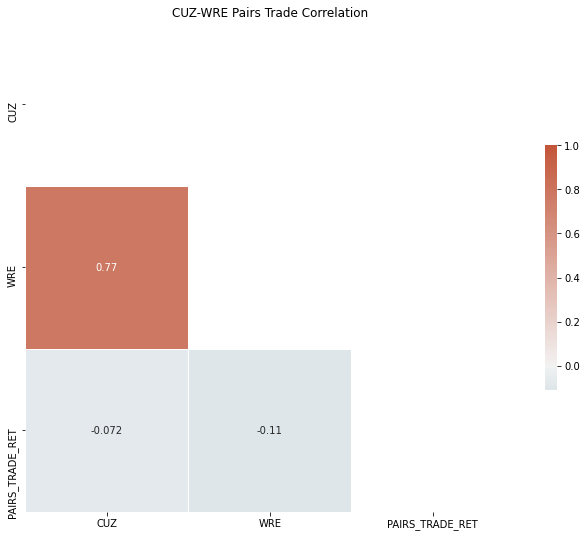

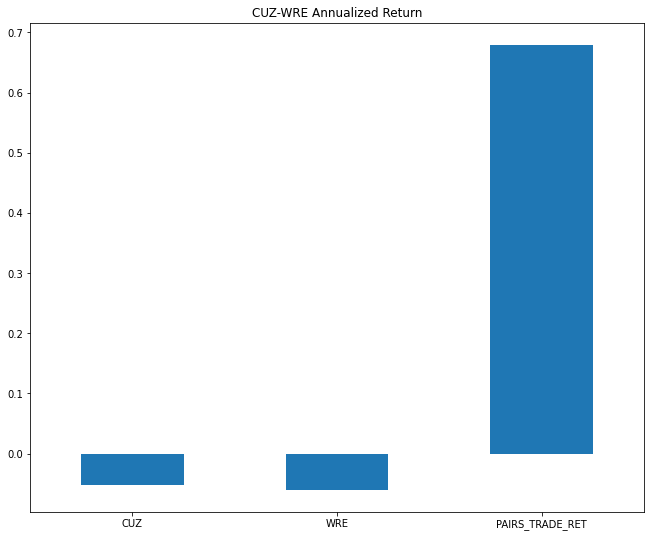

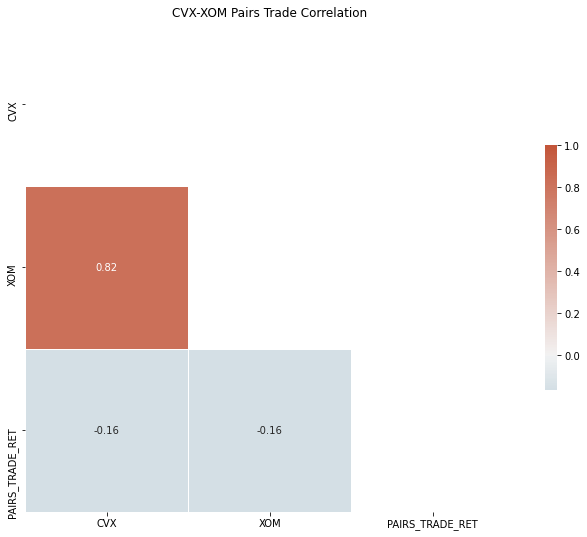

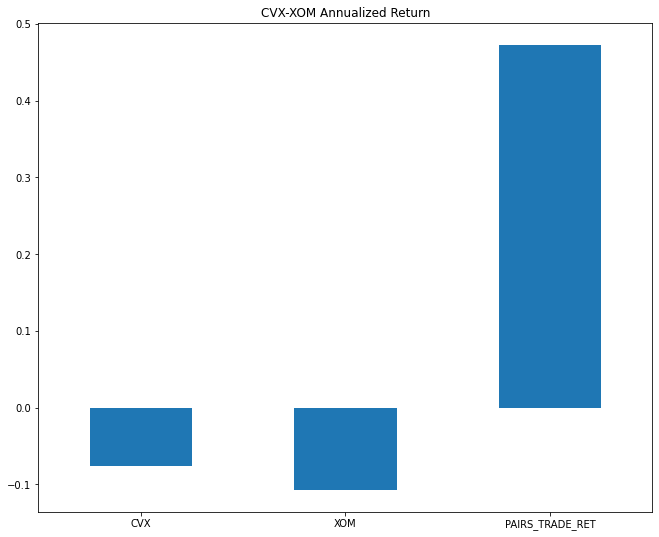

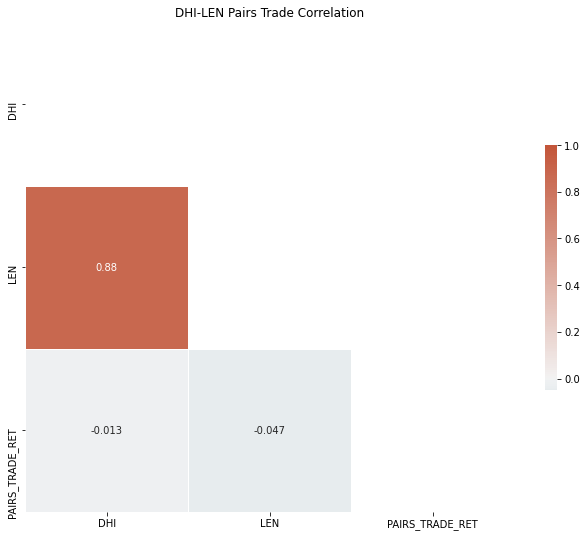

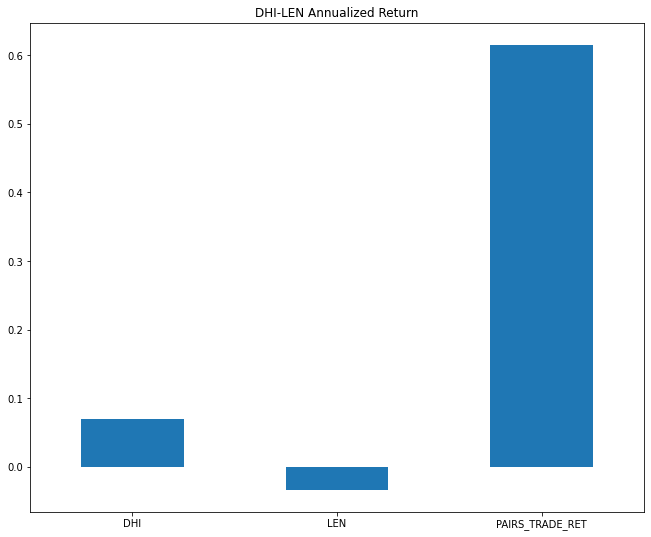

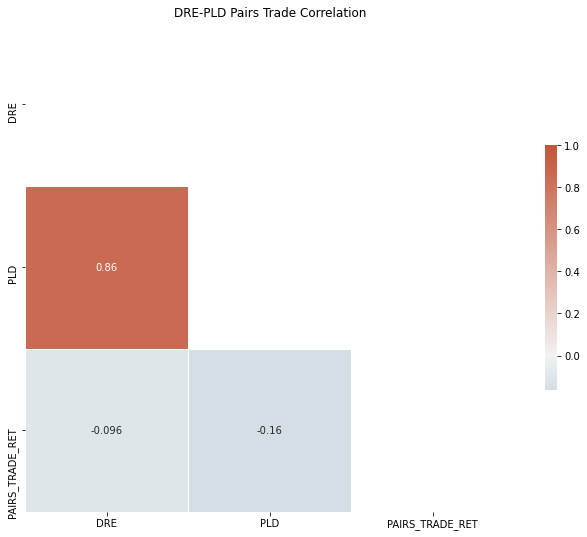

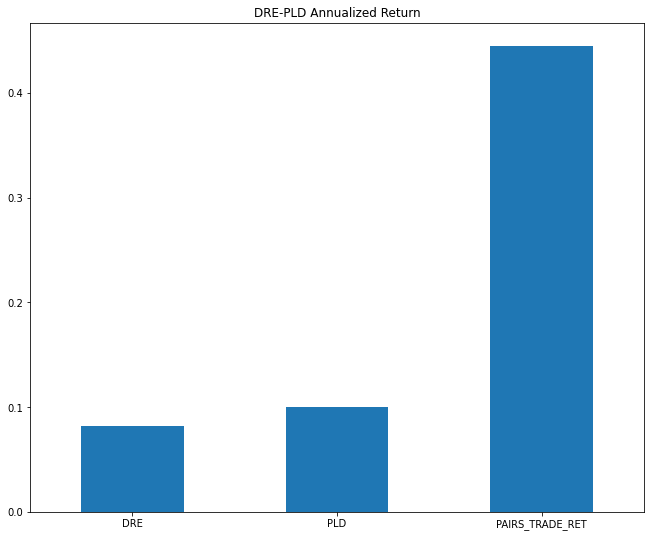

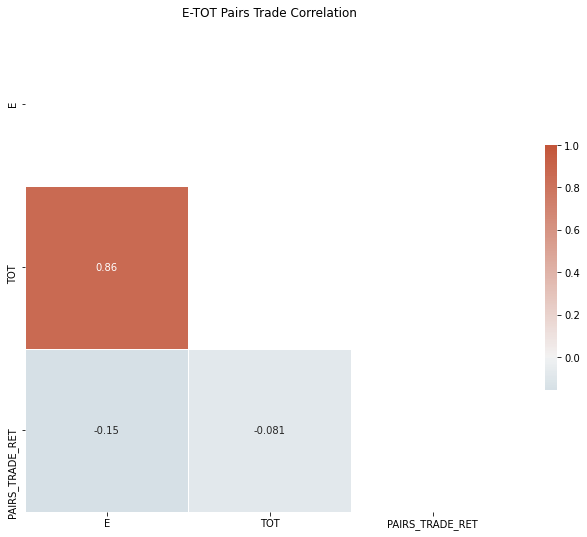

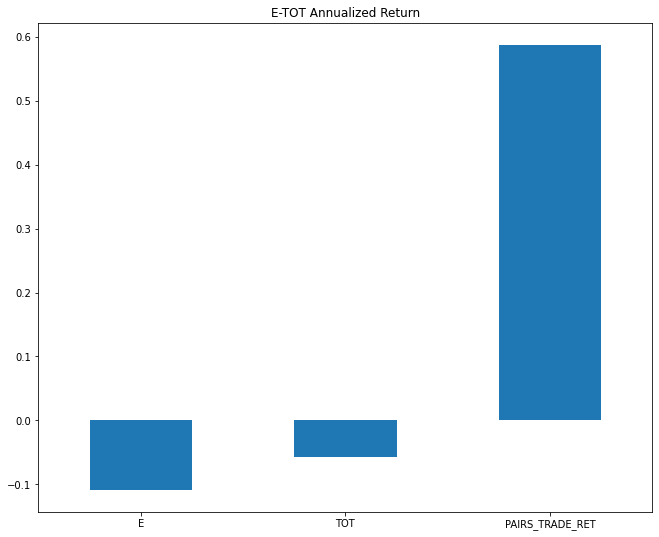

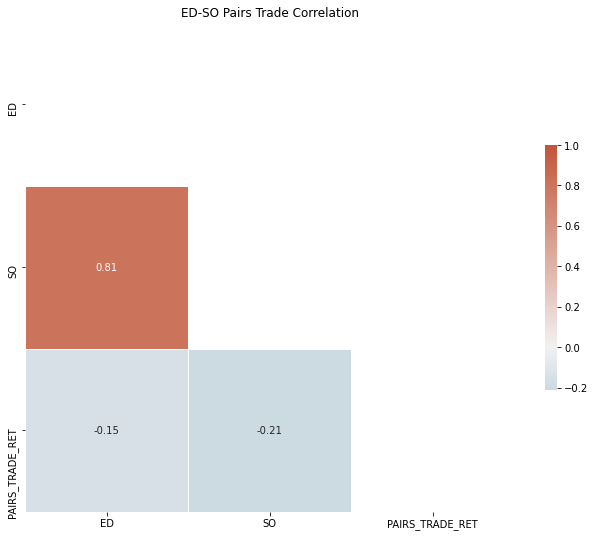

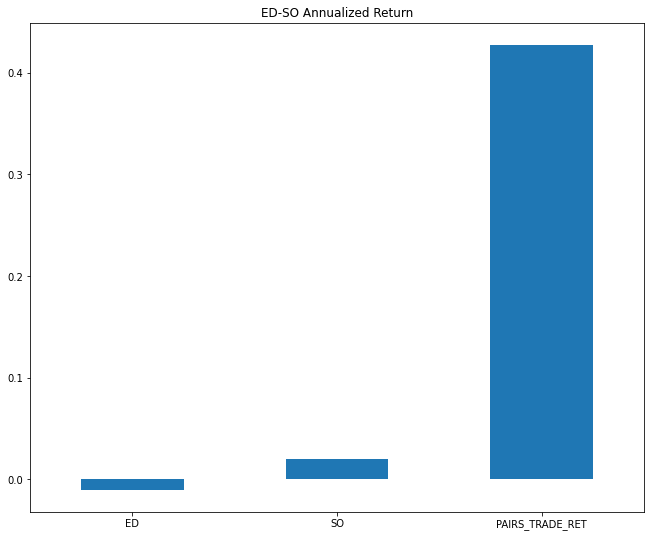

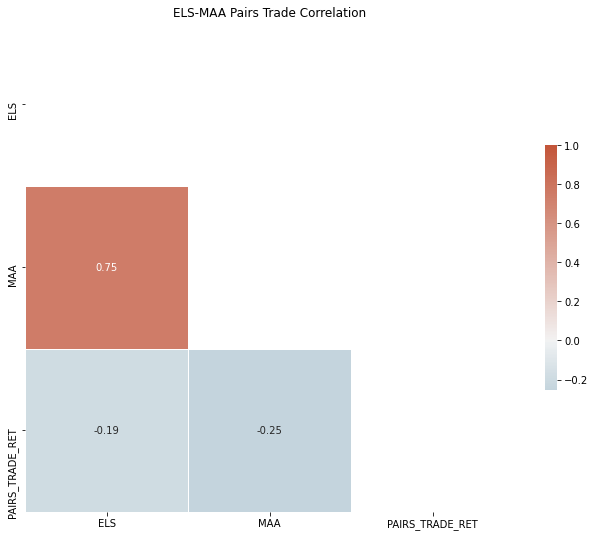

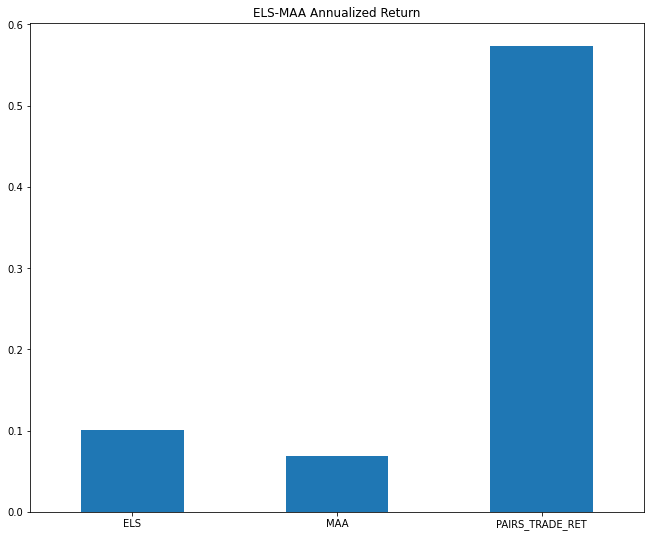

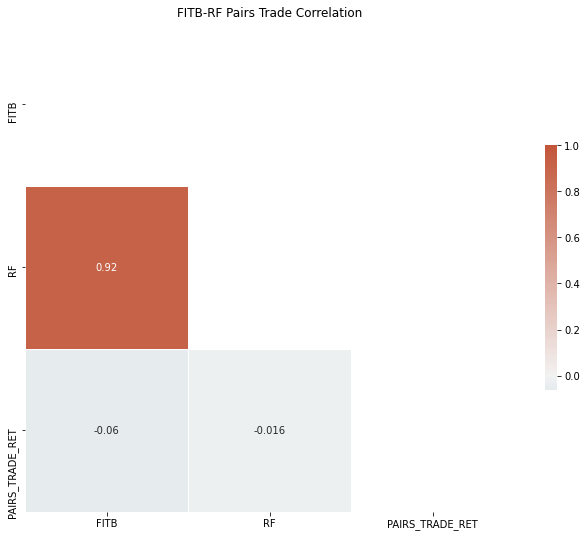

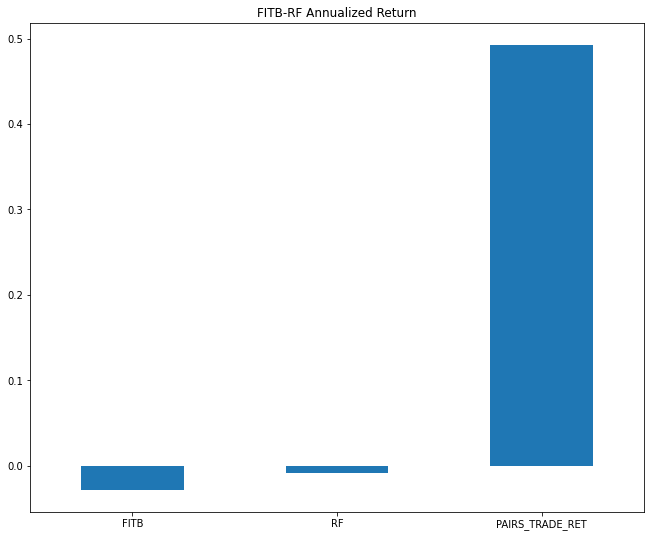

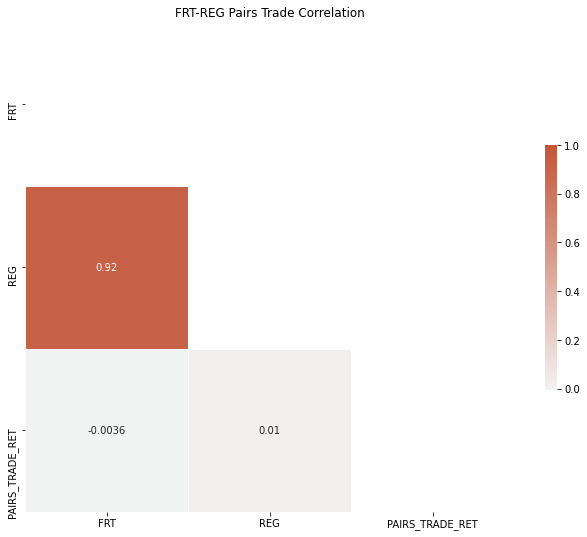

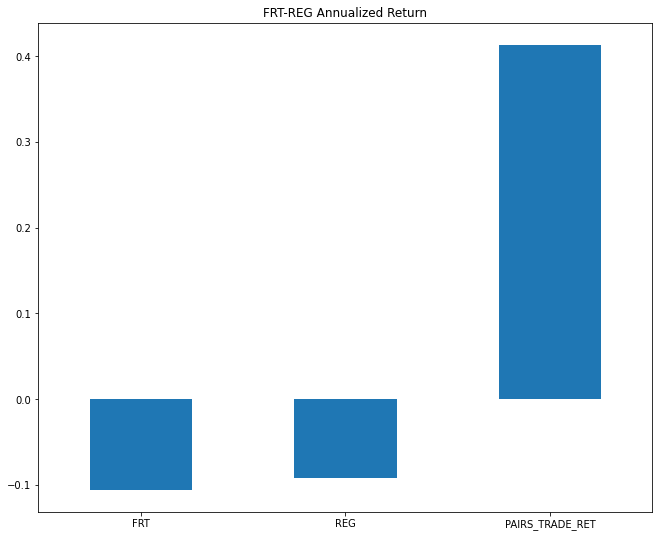

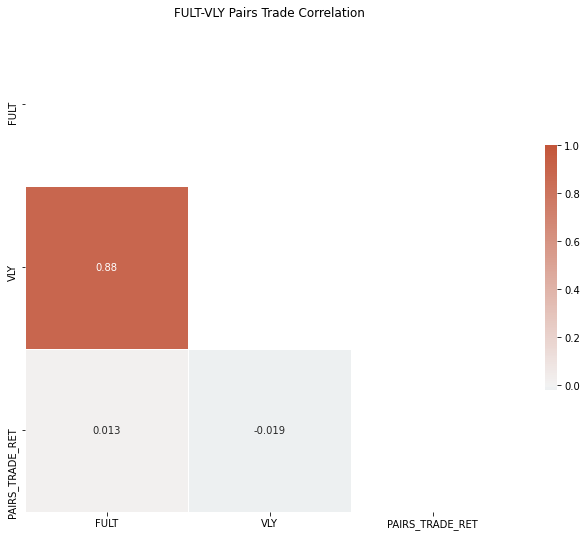

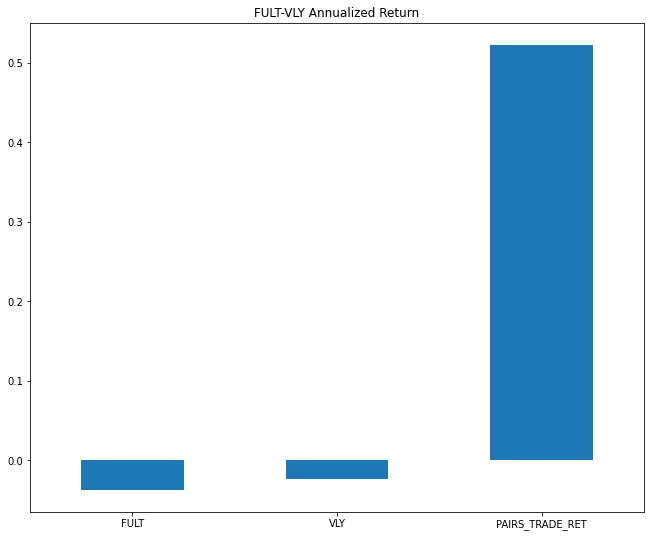

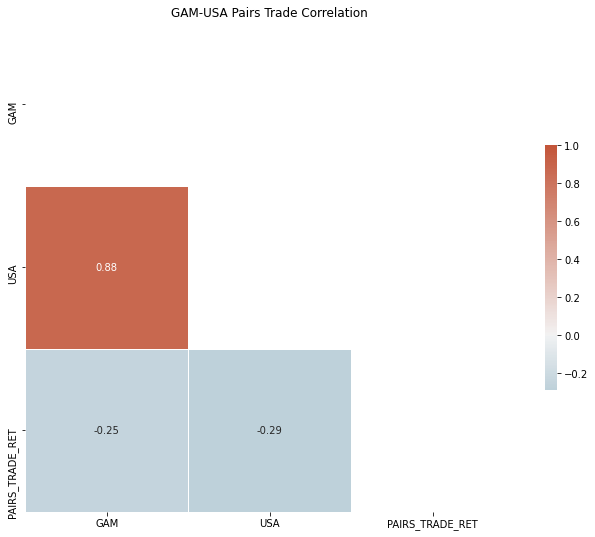

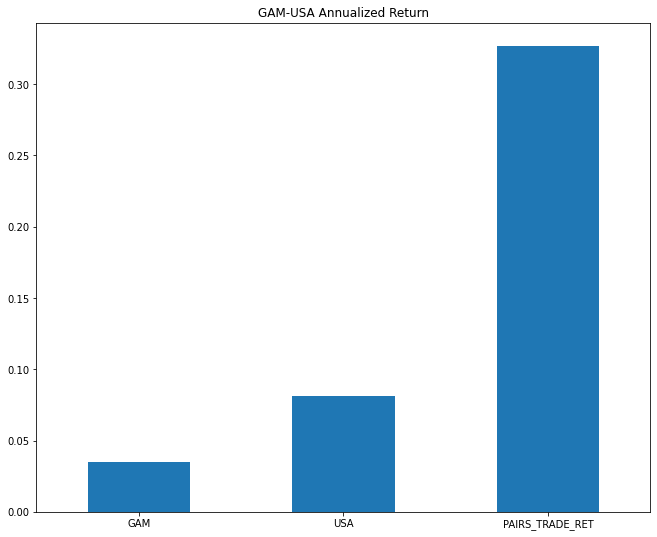

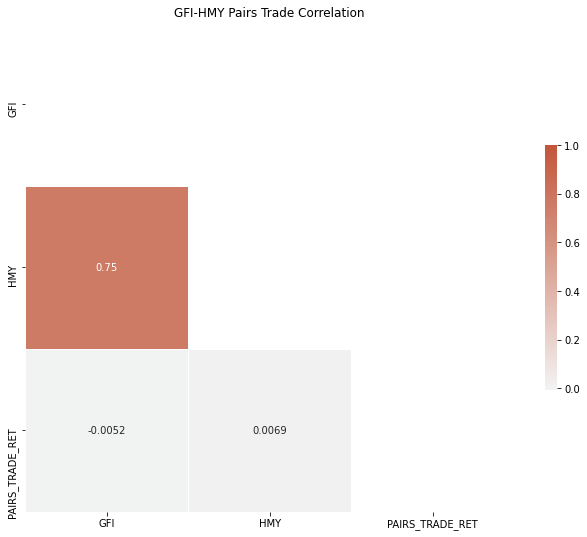

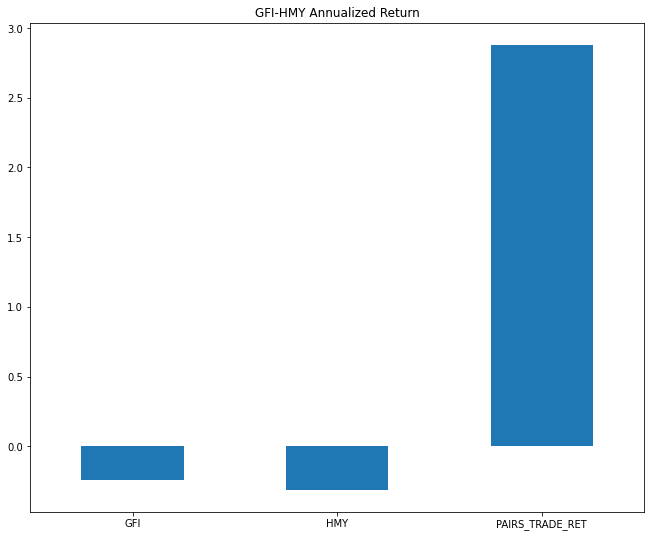

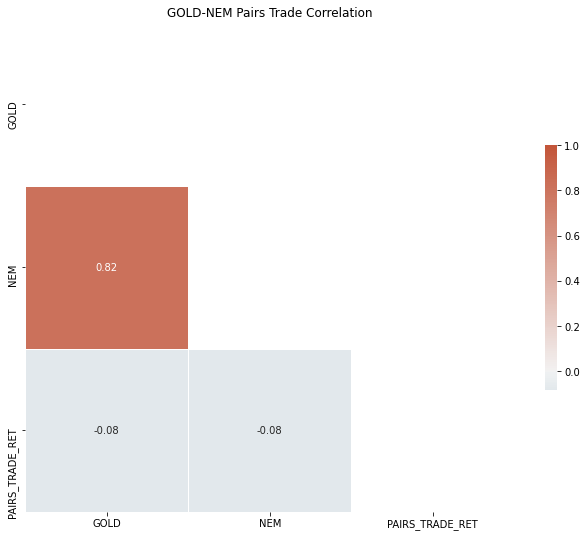

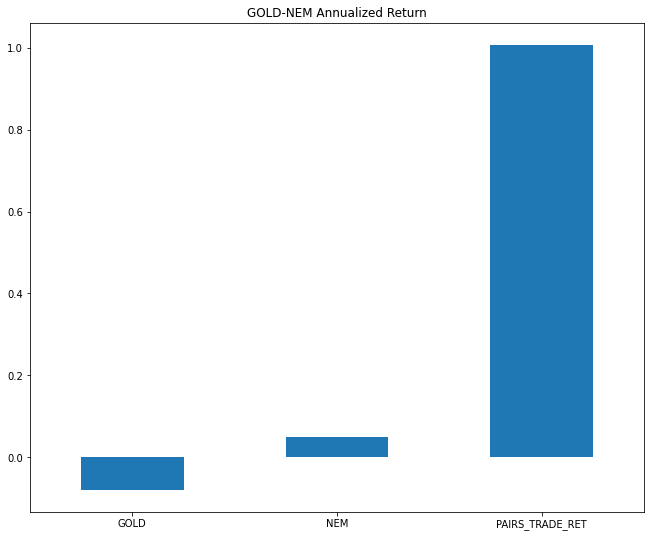

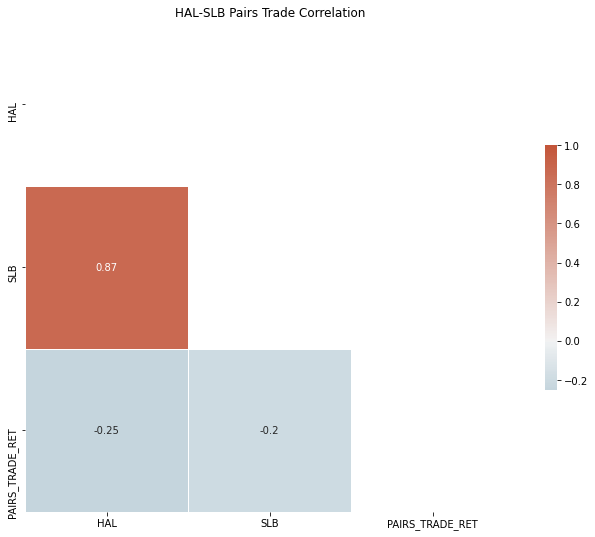

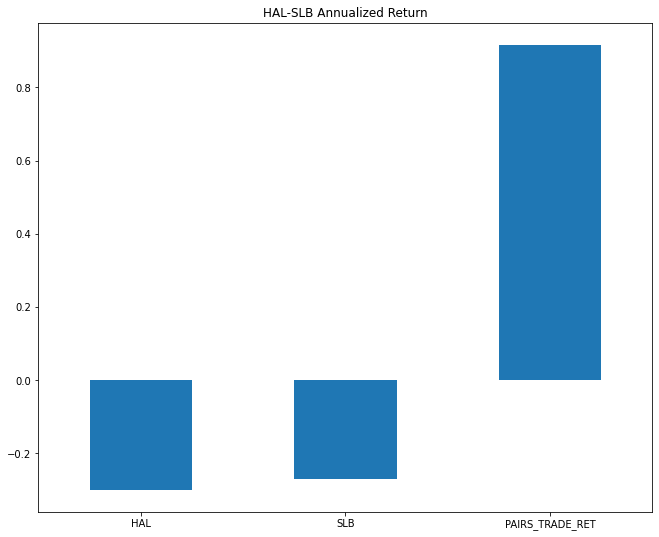

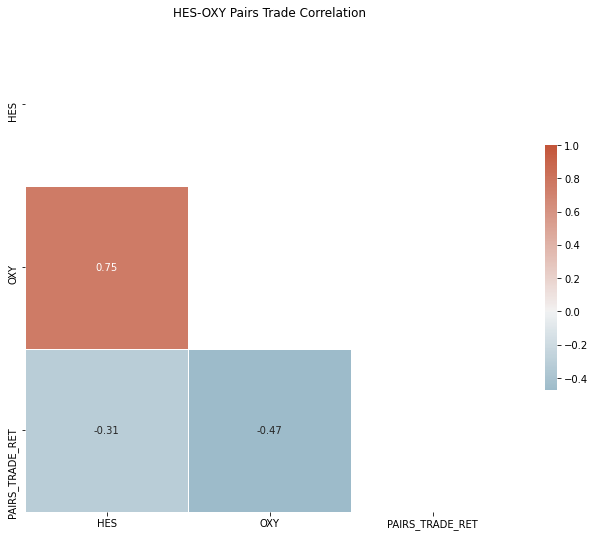

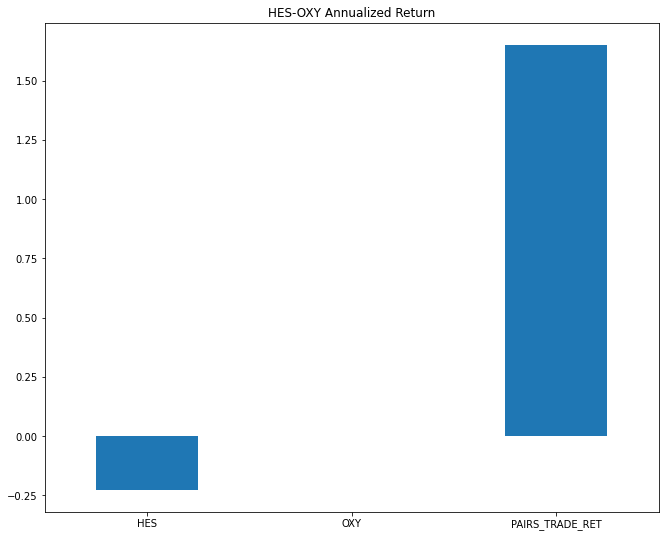

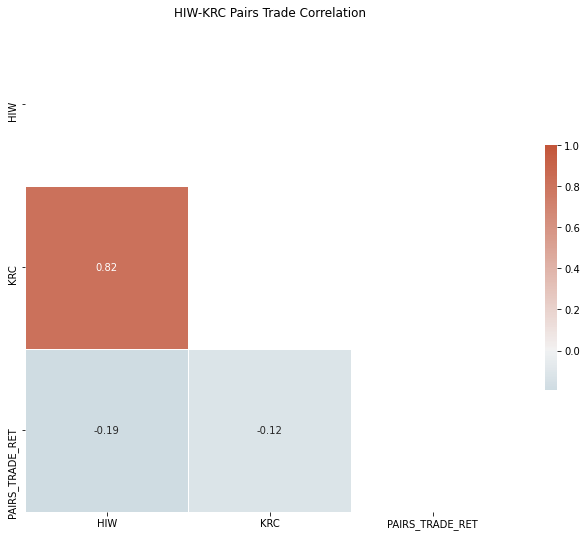

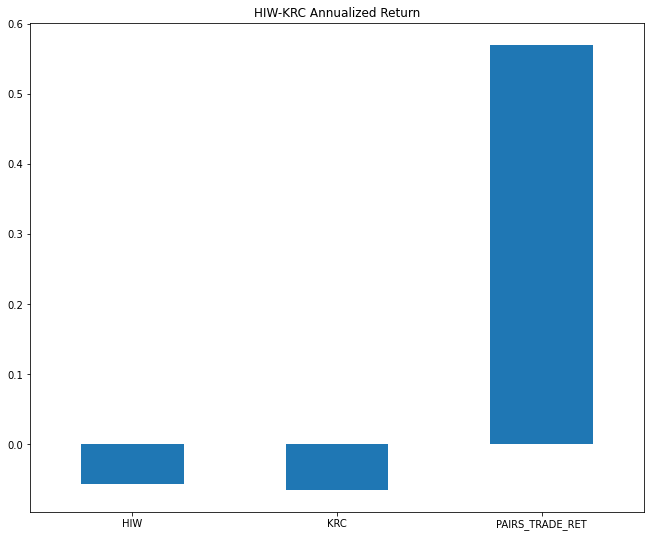

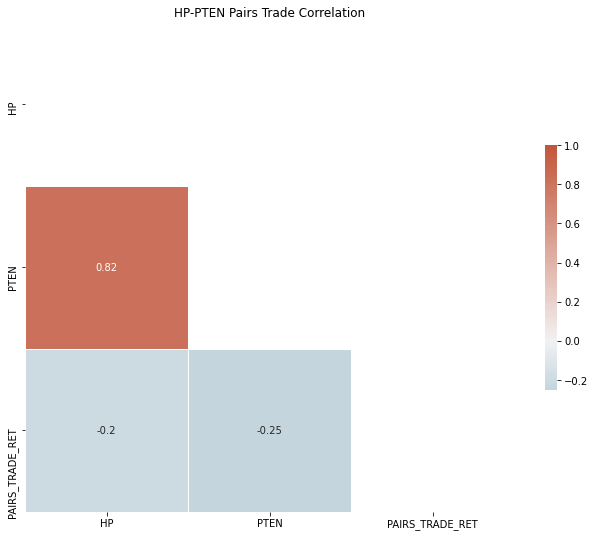

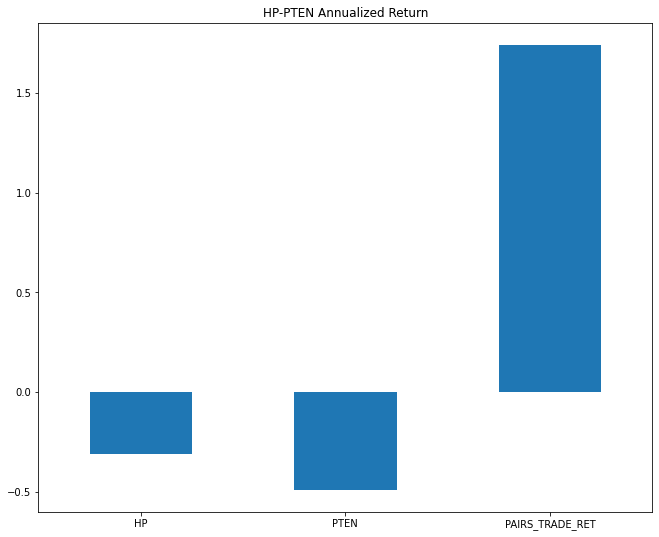

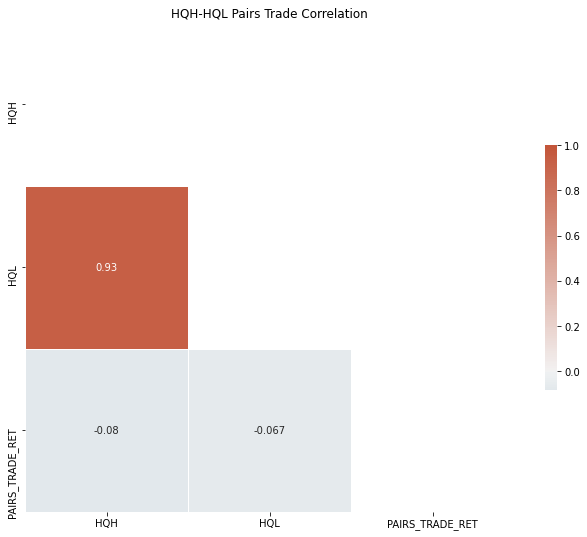

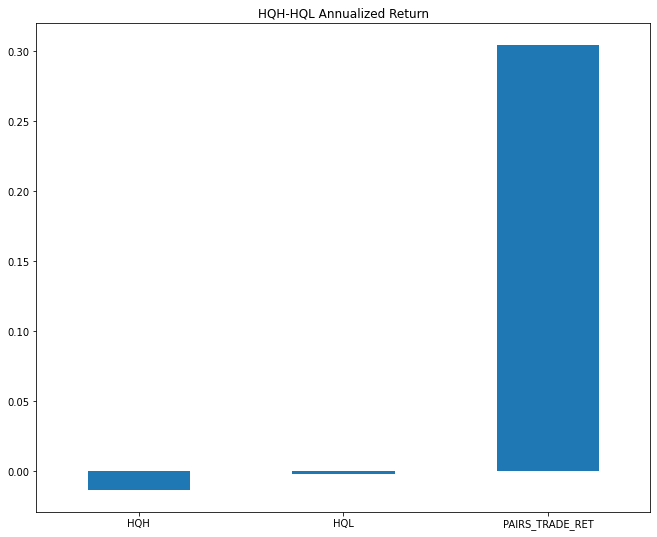

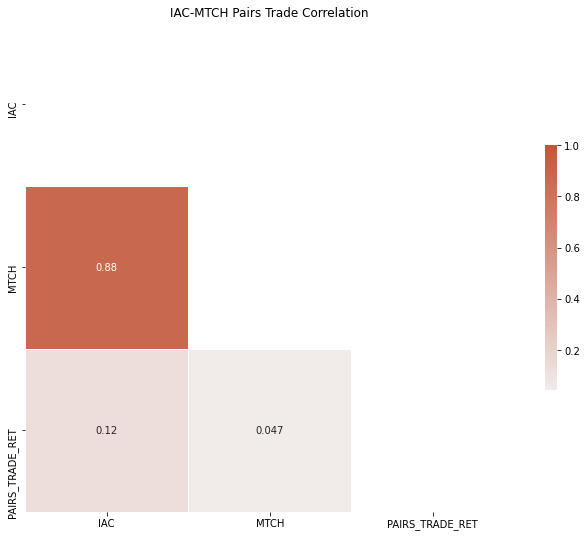

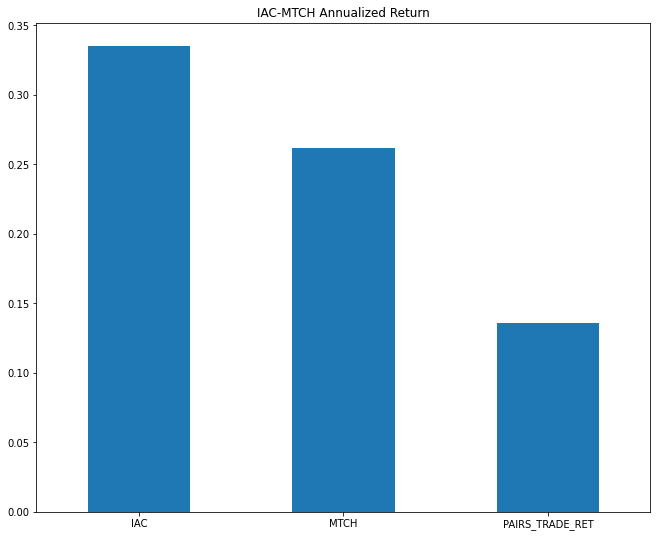

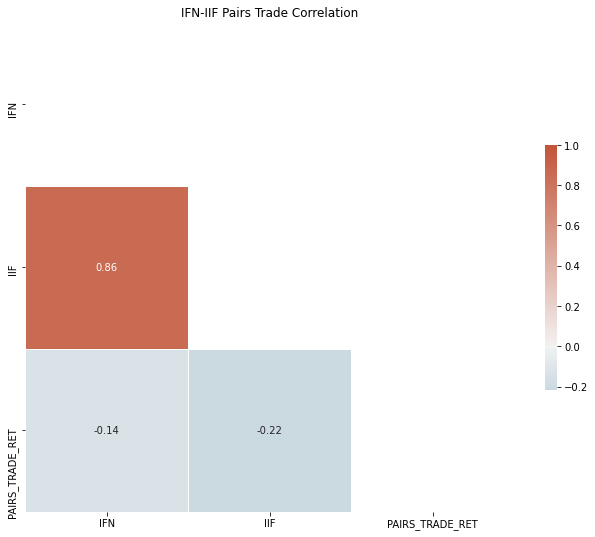

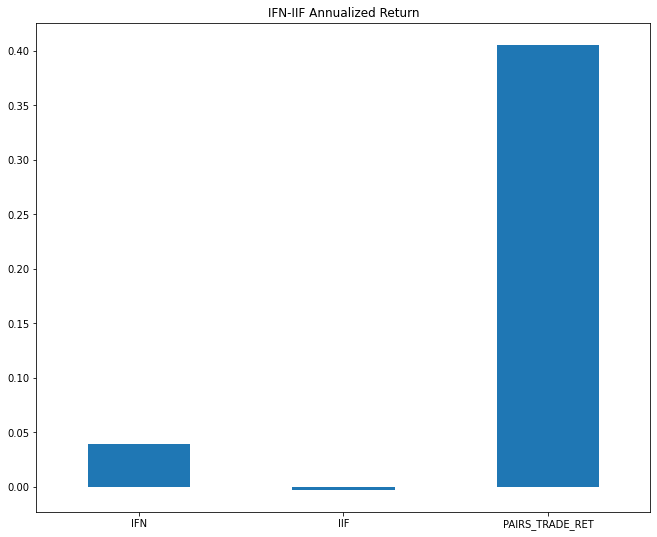

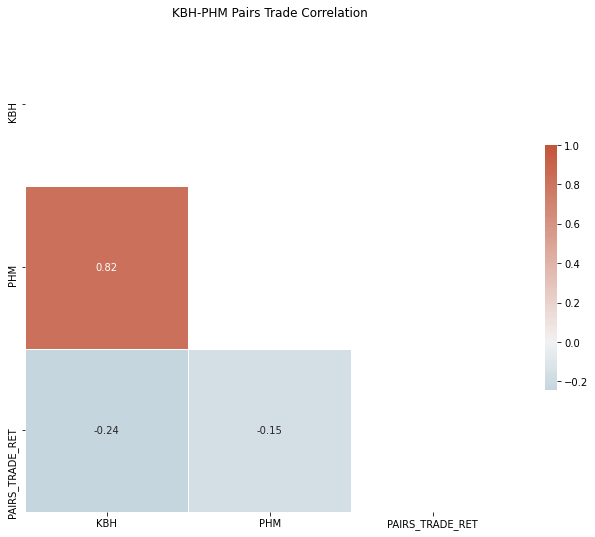

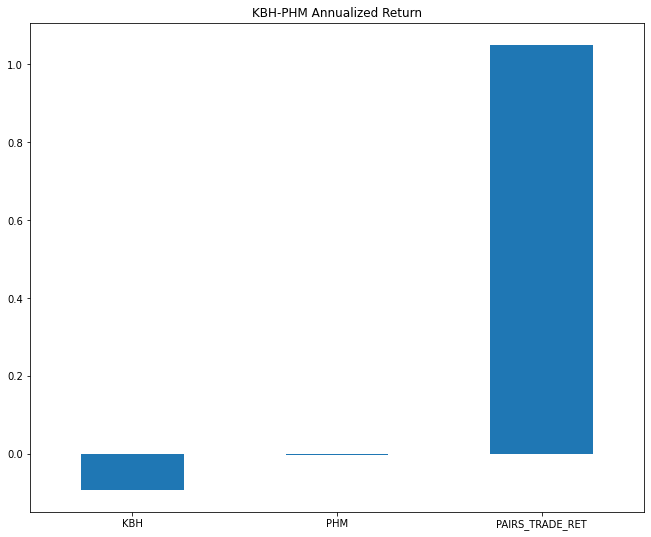

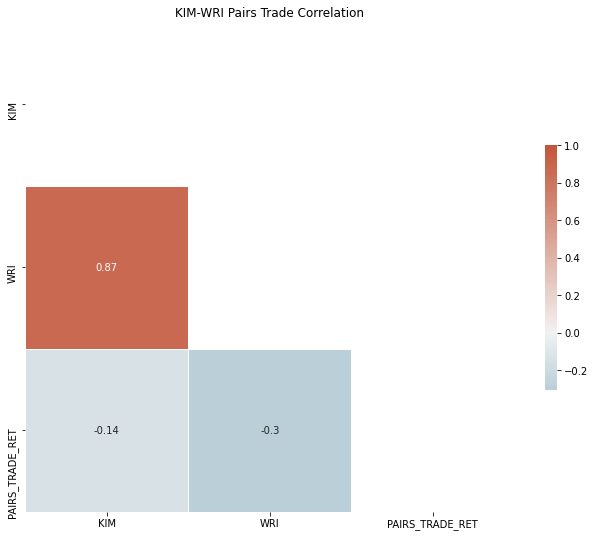

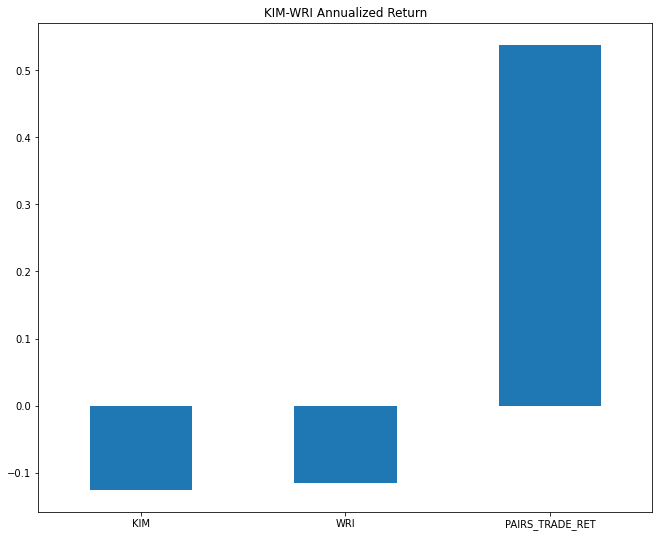

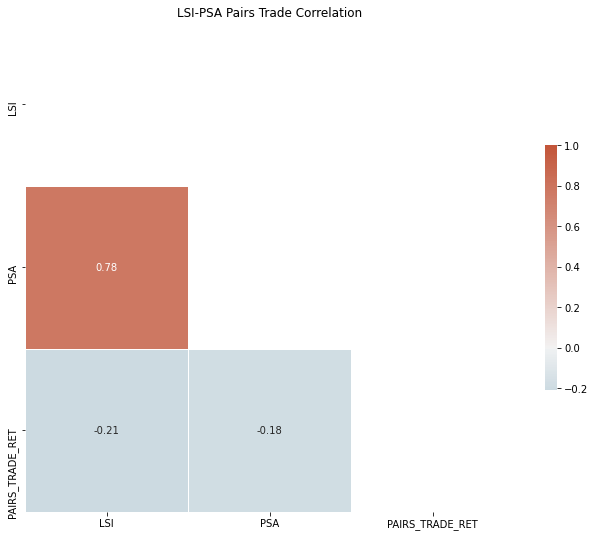

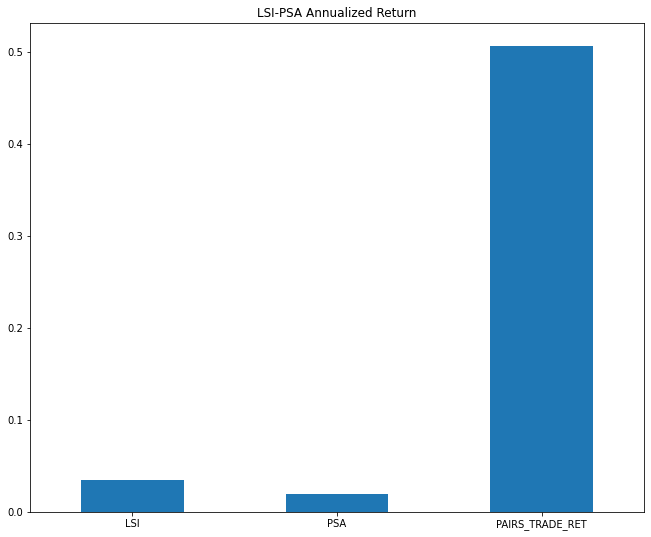

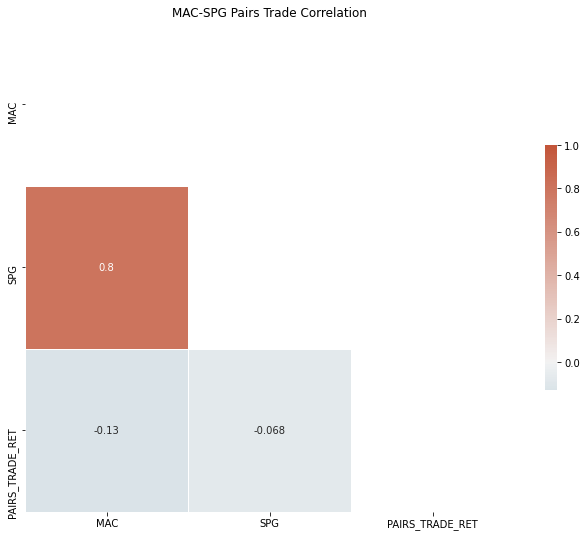

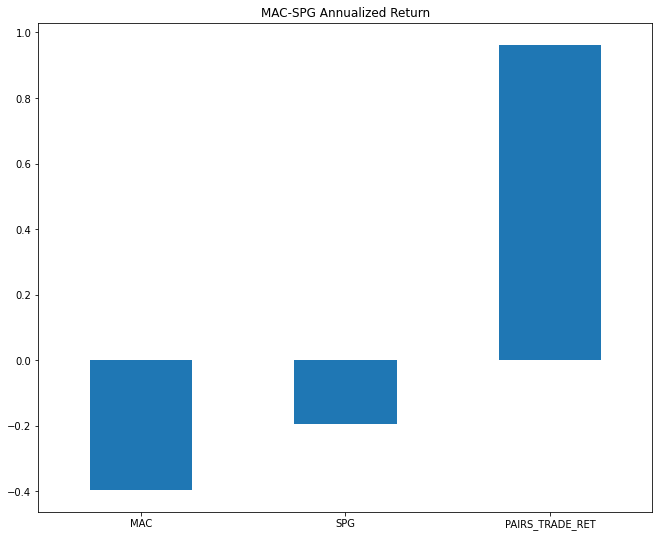

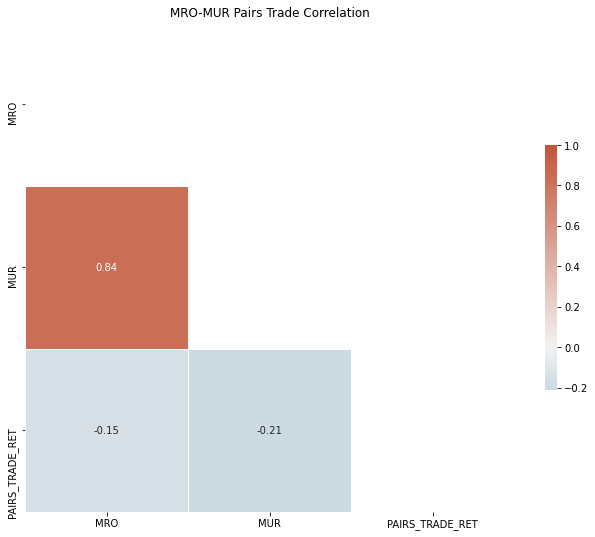

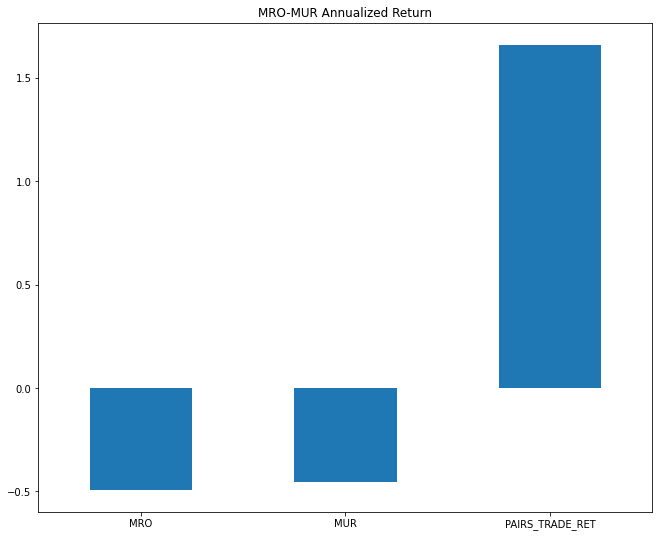

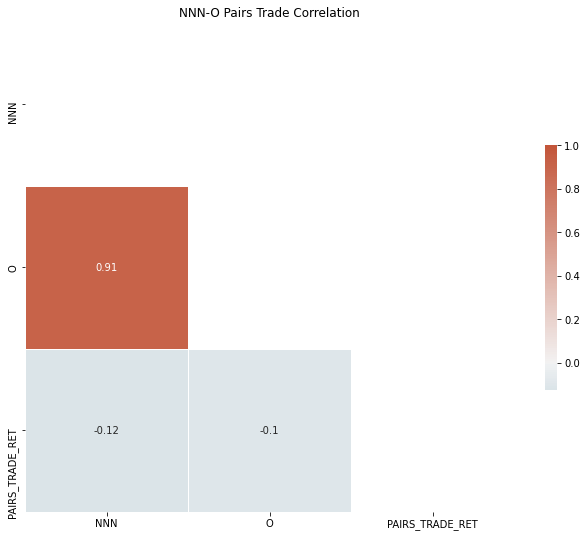

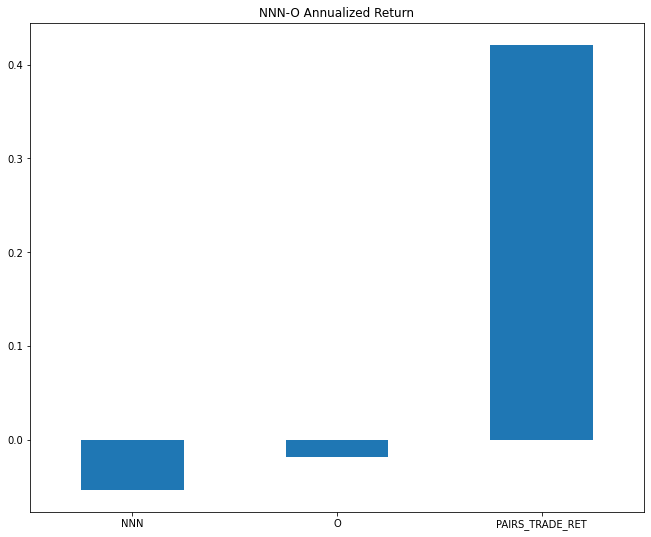

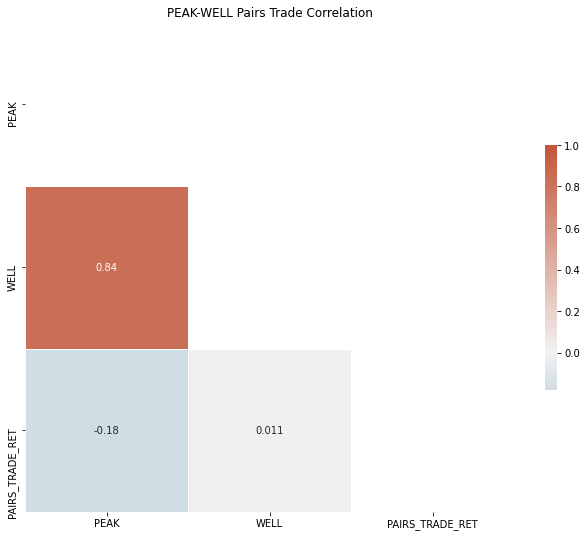

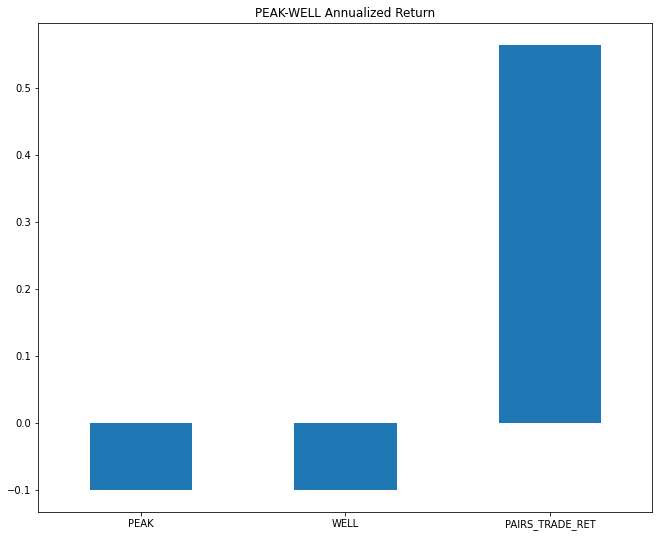

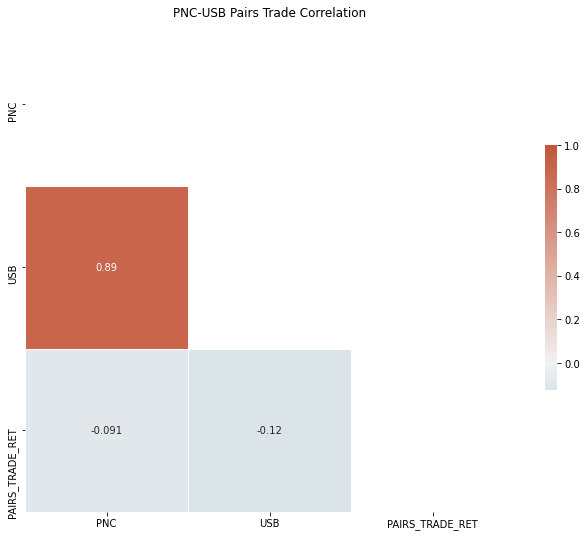

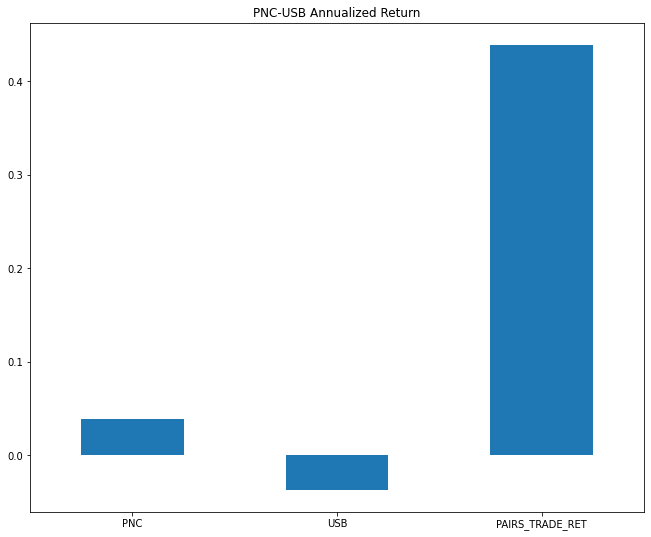

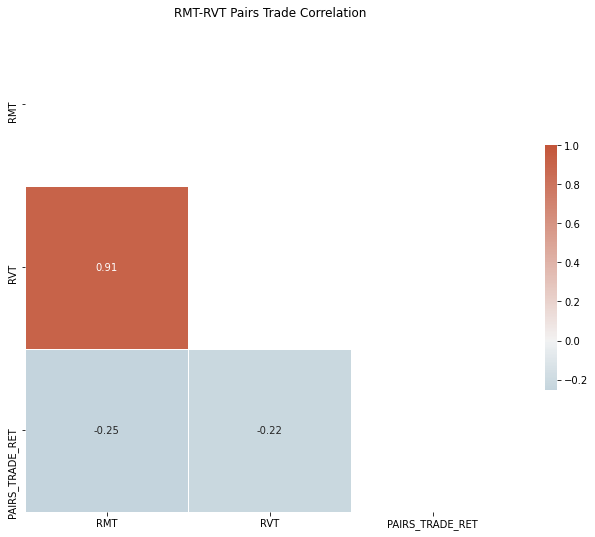

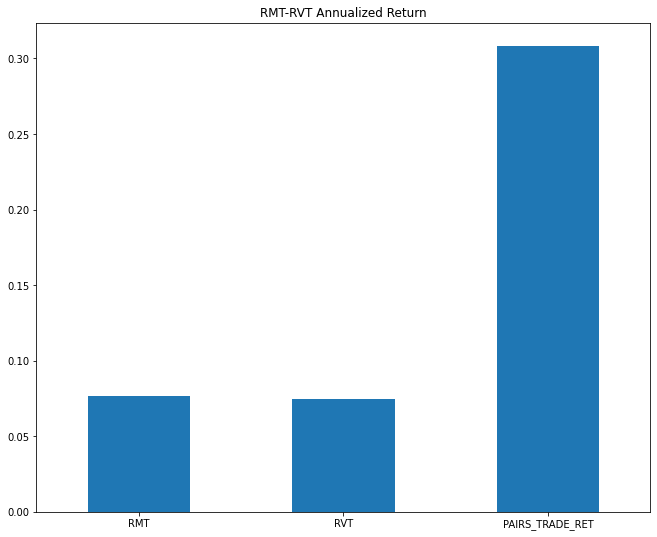

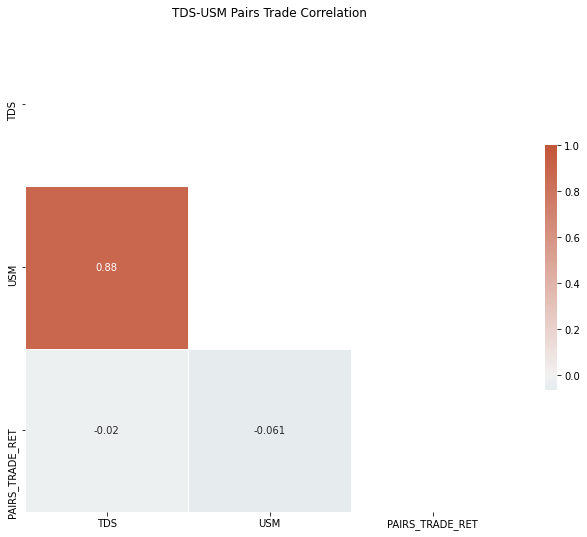

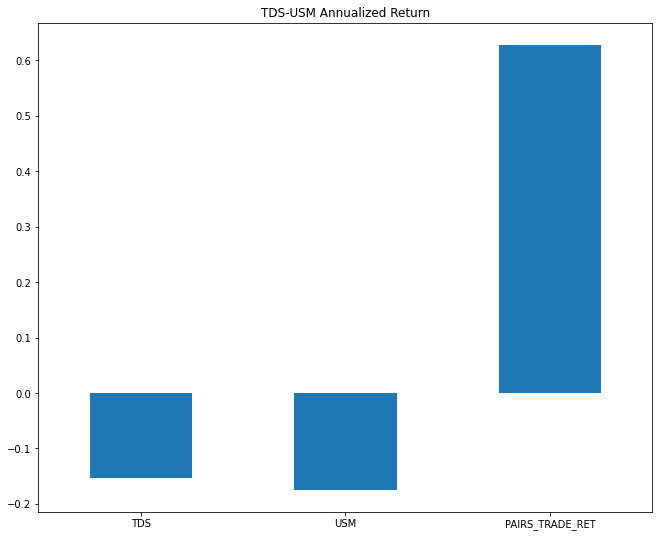

In [10]:
def signal_to_multiplier(signal, long):
    if           signal == -1.0: return -0.50 * long
    elif -1.0 <  signal <= -0.5: return -0.25 * long
    elif -0.5 <  signal <= -0.0: return -0.10 * long
    elif  0.0 <= signal <   0.5: return  0.10 * long
    elif  0.5 <= signal <   1.0: return  0.25 * long
    elif         signal ==  1.0: return  0.50 * long
    else: raise ValueError("Out of range signal provided")

returns = {}
for data_file in data_filenames:
    pairs = data_file[:-4].split('-')
    pair = (pairs[0], pairs[1])
    print(pair)

    returns[pair] = pd.read_pickle(f"data/raw/{pair[0]}.zip").loc["2015-01-01":, ["Simple Return"]]
    returns[pair][pair[1]] = pd.read_pickle(f"data/raw/{pair[1]}.zip").loc["2015-01-01":, ["Simple Return"]]
    returns[pair].columns = pair

    pair_df = pd.read_pickle(os.path.join(data_path, data_file))
    X_train = pair_df.loc["2000-01-01":"2014-12-31", :].drop(columns="Return Diff (t+1)")
    y_train = pair_df.loc["2000-01-01":"2014-12-31", ["Return Diff (t+1)"]]
    X_test = pair_df.loc["2015-01-01":, :].drop(columns="Return Diff (t+1)")
    y_test = pair_df.loc["2015-01-01":, ["Return Diff (t+1)"]]

    # fill invalid values with 1 (for ratios) or 0 (for differences)
    X_train[X_train.isin([-np.inf, np.inf, np.nan])] = 1
    y_train[y_train.isin([-np.inf, np.inf, np.nan])] = 0
    X_test[X_test.isin([-np.inf, np.inf, np.nan])] = 1
    y_test[y_test.isin([-np.inf, np.inf, np.nan])] = 0

    # add in quantiles as additional feature columns
    quantile_transformer = feature_transformers[pair]
    X_train.loc[:, [col + "_QUANTILE" for col in X_train.columns]] = pd.DataFrame(
        pd.DataFrame(quantile_transformer.transform(X_train), index=X_train.index,
                     columns=[col + "_QUANTILE" for col in X_train.columns]))
    X_test.loc[:, [col + "_QUANTILE" for col in X_test.columns]] = pd.DataFrame(
        pd.DataFrame(quantile_transformer.transform(X_test), index=X_test.index,
                     columns=[col + "_QUANTILE" for col in X_test.columns]))

    # fill invalid values with 1 (for ratios) or 0 (for differences)
    X_train[X_train.isin([-np.inf, np.inf, np.nan])] = 1
    y_train[y_train.isin([-np.inf, np.inf, np.nan])] = 0
    X_test[X_test.isin([-np.inf, np.inf, np.nan])] = 1
    y_test[y_test.isin([-np.inf, np.inf, np.nan])] = 0

    # scale features and target column
    X_scaler = feature_scalers[pair]
    X_train = pd.DataFrame(X_scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(X_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    assert not any([any(arr) for arr in np.array(np.isinf(X_train))])
    assert not any([any(arr) for arr in np.array(np.isnan(X_train))])
    assert not any([any(arr) for arr in np.array(np.isinf(X_test))])
    assert not any([any(arr) for arr in np.array(np.isnan(X_test))])
    assert not any([any(arr) for arr in np.array(np.isinf(y_train))])
    assert not any([any(arr) for arr in np.array(np.isnan(y_train))])
    assert not any([any(arr) for arr in np.array(np.isinf(y_test))])
    assert not any([any(arr) for arr in np.array(np.isnan(y_test))])

    print(f"==================================================\n"
          f"Results for pair {pair}:")
    pred_ensemble = None
    for model_type, model in models[pair].items():
        pred = [-1 if i < 0 else 1 for i in np.array(model.predict(X_test)).ravel()]
        if pred_ensemble is None: pred_ensemble = np.array(pred) / 4
        else: pred_ensemble = pred_ensemble + (np.array(pred) / 4)
        returns[pair][model_type] = pred
    returns[pair]["Ensemble"] = np.mean(
        returns[pair].loc[:, ["Random Forest", "Adaptive Boost", "Gradient Boost", "Neural Net"]], axis=1)
    returns[pair]["Ensemble"] = pred_ensemble
    returns[pair][pair[0] + "_SIGNAL"] = [signal_to_multiplier(sig,  1) for sig in pred_ensemble]
    returns[pair][pair[1] + "_SIGNAL"] = [signal_to_multiplier(sig, -1) for sig in pred_ensemble]
    returns[pair][pair[0] + "_ADJRET"] = returns[pair][pair[0]] * returns[pair][pair[0] + "_SIGNAL"]
    returns[pair][pair[1] + "_ADJRET"] = returns[pair][pair[1]] * returns[pair][pair[1] + "_SIGNAL"]
    returns[pair]["PAIRS_TRADE_RET"] = np.mean(returns[pair][[p+"_ADJRET" for p in pair]], axis=1)
    ann_ret = annualized_return(returns[pair].loc[:, [pair[0],pair[1],"PAIRS_TRADE_RET"]])

    conf_mat = confusion_matrix(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    accuracy = accuracy_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    precision = precision_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    recall = recall_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])
    f1 = f1_score(
        [0 if i < 0 else 1 for i in y_test.to_numpy().ravel()],
        [0 if i < 0 else 1 for i in np.array(pred_ensemble).ravel()])

    print(f"- Ensemble of Random Forest, Adaptive Boost, Gradient Boost, and Recurrent Neural Net\n"
          f"  - Confusion Matrix:\n{conf_mat}\n"
          f"  - Accuracy: {accuracy:.06f}\n"
          f"  - Recall: {recall:.06f}\n"
          f"  - Precision: {precision:.06f}\n"
          f"  - F1-Score: {f1:.06f}\n"
          f"- Annualized Return:\n"
          f"  - {pair[0]}: {ann_ret[pair[0]]:0.06f}\n"
          f"  - {pair[1]}: {ann_ret[pair[1]]:0.06f}\n"
          f"  - Pairs Trade: {ann_ret['PAIRS_TRADE_RET']:0.06f}\n"
          f"--------------------------------------------------")
    print(f"==================================================\n")

    # Compute the correlation matrix
    corr = returns[pair].loc[:, [pair[0],pair[1],"PAIRS_TRADE_RET"]].corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
                          square=True, linewidths=.5, cbar_kws={"shrink": .5})
    heatmap.set_title(f"{pair[0]}-{pair[1]} Pairs Trade Correlation")
    fig = heatmap.get_figure()
    fig.savefig(f"out/img/{pair[0]}-{pair[1]}-corr-rnn.jpeg")

    f, ax = plt.subplots(figsize=(11, 9))
    barplot = ann_ret.plot.bar()
    barplot.set_xticklabels(ann_ret.index, rotation=0)
    barplot.set_title(f"{pair[0]}-{pair[1]} Annualized Return")
    fig = barplot.get_figure()
    fig.savefig(f"out/img/{pair[0]}-{pair[1]}-return-rnn.jpeg")
